In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [216]:
# load in the VDJdb data
df = pd.read_table('/ssd1/dchen/GNN_PEPTIDE_TCR/data/vdjdb_confidence2_trb_hlaa0201_humanonly.tsv', index_col=0)
df = df.reset_index().iloc[:, 1:]
assert sum(df['Epitope'] == 'NLVPMVATV') == sum(df['Epitope gene'] == 'pp65')
assert df['CDR3'].apply(lambda x: x.count(' ')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('_')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('-')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('#')).max() == 0

In [217]:
# create constant maps
amino_acid_charge = {
    'A': 0,  # Alanine
    'R': 1,  # Arginine
    'N': 0,  # Asparagine
    'D': -1,  # Aspartic Acid
    'C': 0,  # Cysteine
    'E': -1,  # Glutamic Acid
    'Q': 0,  # Glutamine
    'G': 0,  # Glycine
    'H': 0,  # Histidine
    'I': 0,  # Isoleucine
    'L': 0,  # Leucine
    'K': 1,  # Lysine
    'M': 0,  # Methionine
    'F': 0,  # Phenylalanine
    'P': 0,  # Proline
    'S': 0,  # Serine
    'T': 0,  # Threonine
    'W': 0,  # Tryptophan
    'Y': 0,  # Tyrosine
    'V': 0,  # Valine
}

# https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html (kd)
amino_acid_hydrophobicity = {
    'A': 1.8,  # Alanine
    'R': -4.5,  # Arginine
    'N': -3.5,  # Asparagine
    'D': -3.5,  # Aspartic Acid
    'C': 2.5,  # Cysteine
    'E': -3.5,  # Glutamic Acid
    'Q': -3.5,  # Glutamine
    'G': -0.4,  # Glycine
    'H': -3.2,  # Histidine
    'I': 4.5,  # Isoleucine
    'L': 3.8,  # Leucine
    'K': -3.9,  # Lysine
    'M': 1.9,  # Methionine
    'F': 2.8,  # Phenylalanine
    'P': -1.6,  # Proline
    'S': -0.8,  # Serine
    'T': -0.7,  # Threonine
    'W': -0.9,  # Tryptophan
    'Y': -1.3,  # Tyrosine
    'V': 4.2,  # Valine
}

amino_acid_weights = {
    'A': 89.09,   # Alanine
    'R': 174.20,  # Arginine
    'N': 132.12,  # Asparagine
    'D': 133.10,  # Aspartic Acid
    'C': 121.16,  # Cysteine
    'E': 147.13,  # Glutamic Acid
    'Q': 146.15,  # Glutamine
    'G': 75.07,   # Glycine
    'H': 155.16,  # Histidine
    'I': 131.18,  # Isoleucine
    'L': 131.18,  # Leucine
    'K': 146.19,  # Lysine
    'M': 149.21,  # Methionine
    'F': 165.19,  # Phenylalanine
    'P': 115.13,  # Proline
    'S': 105.09,  # Serine
    'T': 119.12,  # Threonine
    'W': 204.23,  # Tryptophan
    'Y': 181.19,  # Tyrosine
    'V': 117.15,  # Valine
}

has_sulfur = ['C','M']
is_aromatic = ['F','Y','W']

In [218]:
from tqdm import tqdm
# the first step is the interpolation of nucleotide
alphabet = sorted(set([el for x in df['CDR3'] for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_cdr3s = pd.DataFrame(index=range(df.shape[0]), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for pep_idx in tqdm(X_cdr3s.index):
    # grab peptide
    peptide = df['CDR3'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_cdr3s.loc[pep_idx] = X.values.flatten()

100%|███████████████████████████████████████| 1141/1141 [00:23<00:00, 48.80it/s]


In [219]:
# this second step is repeating the same thing but for the peptides
alphabet = sorted(set([el for x in df['Epitope'] for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_epitopes = pd.DataFrame(index=range(df.shape[0]), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for pep_idx in tqdm(X_epitopes.index):
    # grab peptide
    peptide = df['Epitope'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_epitopes.loc[pep_idx] = X.values.flatten()

100%|███████████████████████████████████████| 1141/1141 [00:15<00:00, 73.06it/s]


In [220]:
# define y
y = pd.Series(1, index=X_cdr3s.index)

In [221]:
# join together the two dataframes
X_cdr3s.columns = 'cdr3:' + X_cdr3s.columns
X_epitopes.columns = 'ag:' + X_epitopes.columns

In [222]:
# reclaim cdr3 alphabet
alphabet_cdr3 = sorted(set([el for x in df['CDR3'] for el in list(x)]))
# reclaim epitope alphabet
alphabet_epitope = sorted(set([el for x in df['Epitope'] for el in list(x)]))

In [223]:
# now we need to add a few control elements
# for each given peptide, i want to randomly select TCRs that do not bind to it of equal number
np.random.seed(0)
for _, (epitope, n_tcrs) in tqdm(df['Epitope'].value_counts().reset_index().iterrows()):
    # grab peptide
    peptide = df['Epitope'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet_epitope] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_epitope = X.values.flatten()
    
    # make sure we are not getting this epitope nor cdr3s known to bind to this epitope
    mask = df['Epitope'] != epitope
    cdr3s_epitope = df.loc[df['Epitope'] == epitope, 'CDR3'].unique()
    mask = mask & (~df['CDR3'].isin(cdr3s_epitope))
    
    # now lets select with replacement the other ones
    cdr3s = np.random.choice(df.loc[mask, 'CDR3'], size=n_tcrs, replace=True)
    
    for cdr3 in cdr3s:
        # grab peptide
        peptide = df['CDR3'].iloc[pep_idx]
        # create the tracking dataframe
        X = pd.DataFrame(np.nan, index=range(100), columns=columns)
        step = 100 / len(peptide)
        for idx, aa in enumerate(peptide):
            # find start and end of each peptide
            start, end = round(idx * step), round((idx + 1) * step)
            if idx == len(peptide) - 1:
                end = 100
            # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
            charge = amino_acid_charge[aa]
            hydrophobicity = amino_acid_hydrophobicity[aa] / 2
            weight = amino_acid_weights[aa] / 100
            sulfur = 1 * (aa in has_sulfur)
            aromatic = 1 * (aa in is_aromatic)
            X.loc[start:end, alphabet_cdr3] = 0
            X.loc[start:end, aa] = 1
            X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
        assert not X.isna().any().any()
        X_cdr3 = X.values.flatten()
        # append
        X_cdr3s.loc[X_cdr3s.shape[0]] = X_cdr3
        X_epitopes.loc[X_epitopes.shape[0]] = X_epitope
        y.loc[y.shape[0]] = 0

127it [07:13,  3.41s/it]


In [224]:
# rejoin these dataframes together
X = X_cdr3s.join(X_epitopes)
# remove any columns that are constant or all zero
X = X.loc[:, X.abs().sum(0) > 0]
X = X.loc[:, X.nunique(0) > 1]

In [225]:
# now display the number of arguments post filtering
X.shape[1]

3807

In [226]:
# normalize
means = X.mean()
X -= X.mean()
stds = X.std()
X /= X.std()

In [227]:
# write normalization factors
means.to_csv('../outputs/vdjdb/model_v2.means.csv')
stds.to_csv('../outputs/vdjdb/model_v2.stds.csv')

In [14]:
# naively work through everything at once

In [15]:
# now let's create the logit model
clf = LogisticRegression(max_iter=1000).fit(X, y)
clf.score(X, y)

0.9995617879053462

<AxesSubplot:xlabel='Hit', ylabel='Probability'>

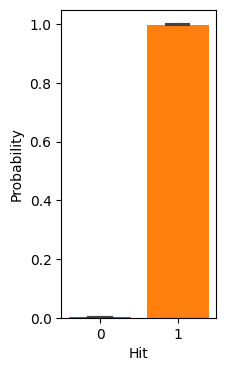

In [16]:
# retrieve probabilities
probs = pd.DataFrame(clf.predict_proba(X)[:, 1], index=y.index, columns=['Probability'])
probs['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
sns.barplot(x='Hit', y='Probability', data=probs, ci=95, errwidth=1.5, capsize=0.3, saturation=1)

In [19]:
!mkdir ../outputs/vdjdb

In [20]:
# save these datasets
X.to_csv('../outputs/vdjdb/trb_ag.X.csv')
y.to_csv('../outputs/vdjdb/trb_ag.y.csv')

In [10]:
# read these datasets
X = pd.read_csv('../outputs/vdjdb/trb_ag.X.csv', index_col=0)
y = pd.read_csv('../outputs/vdjdb/trb_ag.y.csv', index_col=0)['0']

In [119]:
# now let's do true cross validation

In [15]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []
aucs = []
probs = []
coefs = []
for idxs, idys in sss.split(X, y):
    # train on idxs
    clf = LogisticRegression(max_iter=1000, random_state=0).fit(X.iloc[idxs], y.iloc[idxs])
    # scrutinize via idys
    accs.append(clf.score(X.iloc[idys], y.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X.iloc[idys]), y.iloc[idys]))
    prob = pd.Series(clf.predict_proba(X.iloc[idys])[:, 1], index=y.iloc[idys].index)
    probs.append(prob)
    coefs.append(pd.Series(clf.coef_[0], index=clf.feature_names_in_))
    print('.', end='')

....................................................................................................

0.9995971978984238 0.0001444538907478147
0.9995985721595477 0.00014396133394456112


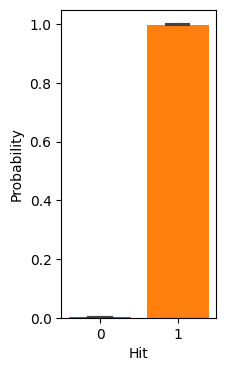

In [16]:
# retrieve probabilities
probs = pd.DataFrame(clf.predict_proba(X)[:, 1], index=y.index, columns=['Probability'])
probs['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
sns.barplot(x='Hit', y='Probability', data=probs, ci=95, errwidth=1.5, capsize=0.3, saturation=1)
print(np.mean(accs), 1.96 * np.std(accs) / np.sqrt(len(accs)))
print(np.mean(aucs), 1.96 * np.std(aucs) / np.sqrt(len(aucs)))

[Text(0.5, 0, 'Rank'), Text(0, 0.5, 'Coefficient')]

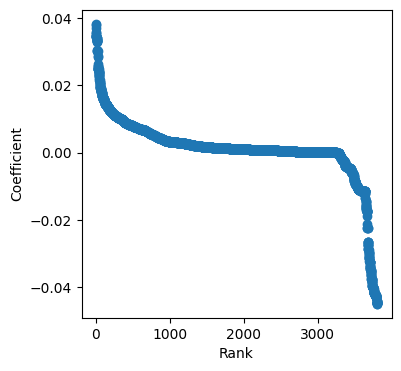

In [17]:
# average the coefficients
coef = pd.concat(coefs, axis=1).mean(1).sort_values()
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(range(coef.shape[0]), coef[::-1])
ax.set(xlabel='Rank', ylabel='Coefficient')

In [21]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []
aucs = []
probs = []
imps = []
for idxs, idys in sss.split(X, y):
    # train on idxs
    clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X.iloc[idxs], y.iloc[idxs])
    # scrutinize via idys
    accs.append(clf.score(X.iloc[idys], y.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X.iloc[idys]), y.iloc[idys]))
    imps.append(pd.Series(clf.feature_importances_, index=clf.feature_names_in_))
    prob = pd.Series(clf.predict_proba(X.iloc[idys])[:, 1], index=y.iloc[idys].index)
    probs.append(prob)
    print('.', end='')

....................................................................................................

[Text(0.5, 0, 'Rank'), Text(0, 0.5, 'Importance')]

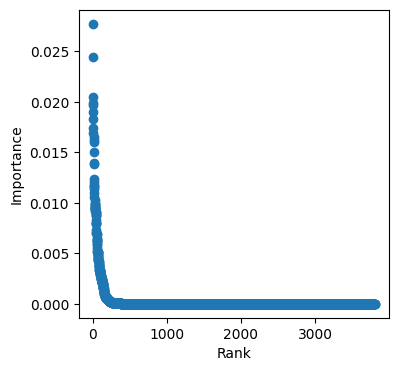

In [22]:
# now compute the importances
imp = pd.concat(imps, axis=1).mean(1).sort_values()
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(range(imp.shape[0]), imp[::-1])
ax.set(xlabel='Rank', ylabel='Importance')

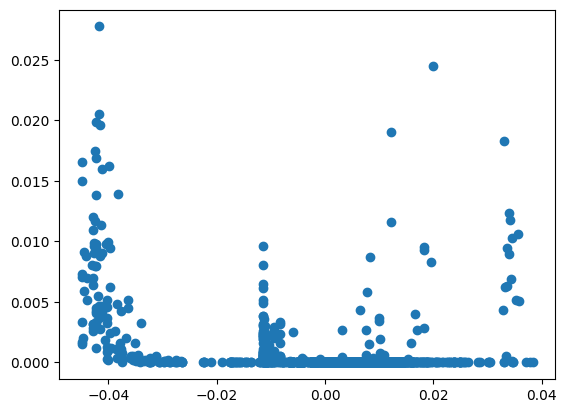

In [23]:
# now let's do a volcano plot
plt.scatter(coef, imp.loc[coef.index])

In [26]:
# save the variable
coef.name = 'coef'
imp.name = 'imp'
pd.DataFrame(coef).join(imp).to_csv('../outputs/vdjdb/trb_ag.coef_imp.csv')

In [128]:
# read in the factors that we want to annotate
import scanpy as sc
sc.settings.set_figure_params(dpi=100)
df = pd.read_csv('../outputs/vdjdb/trb_ag.coef_imp.csv', index_col=0)

500

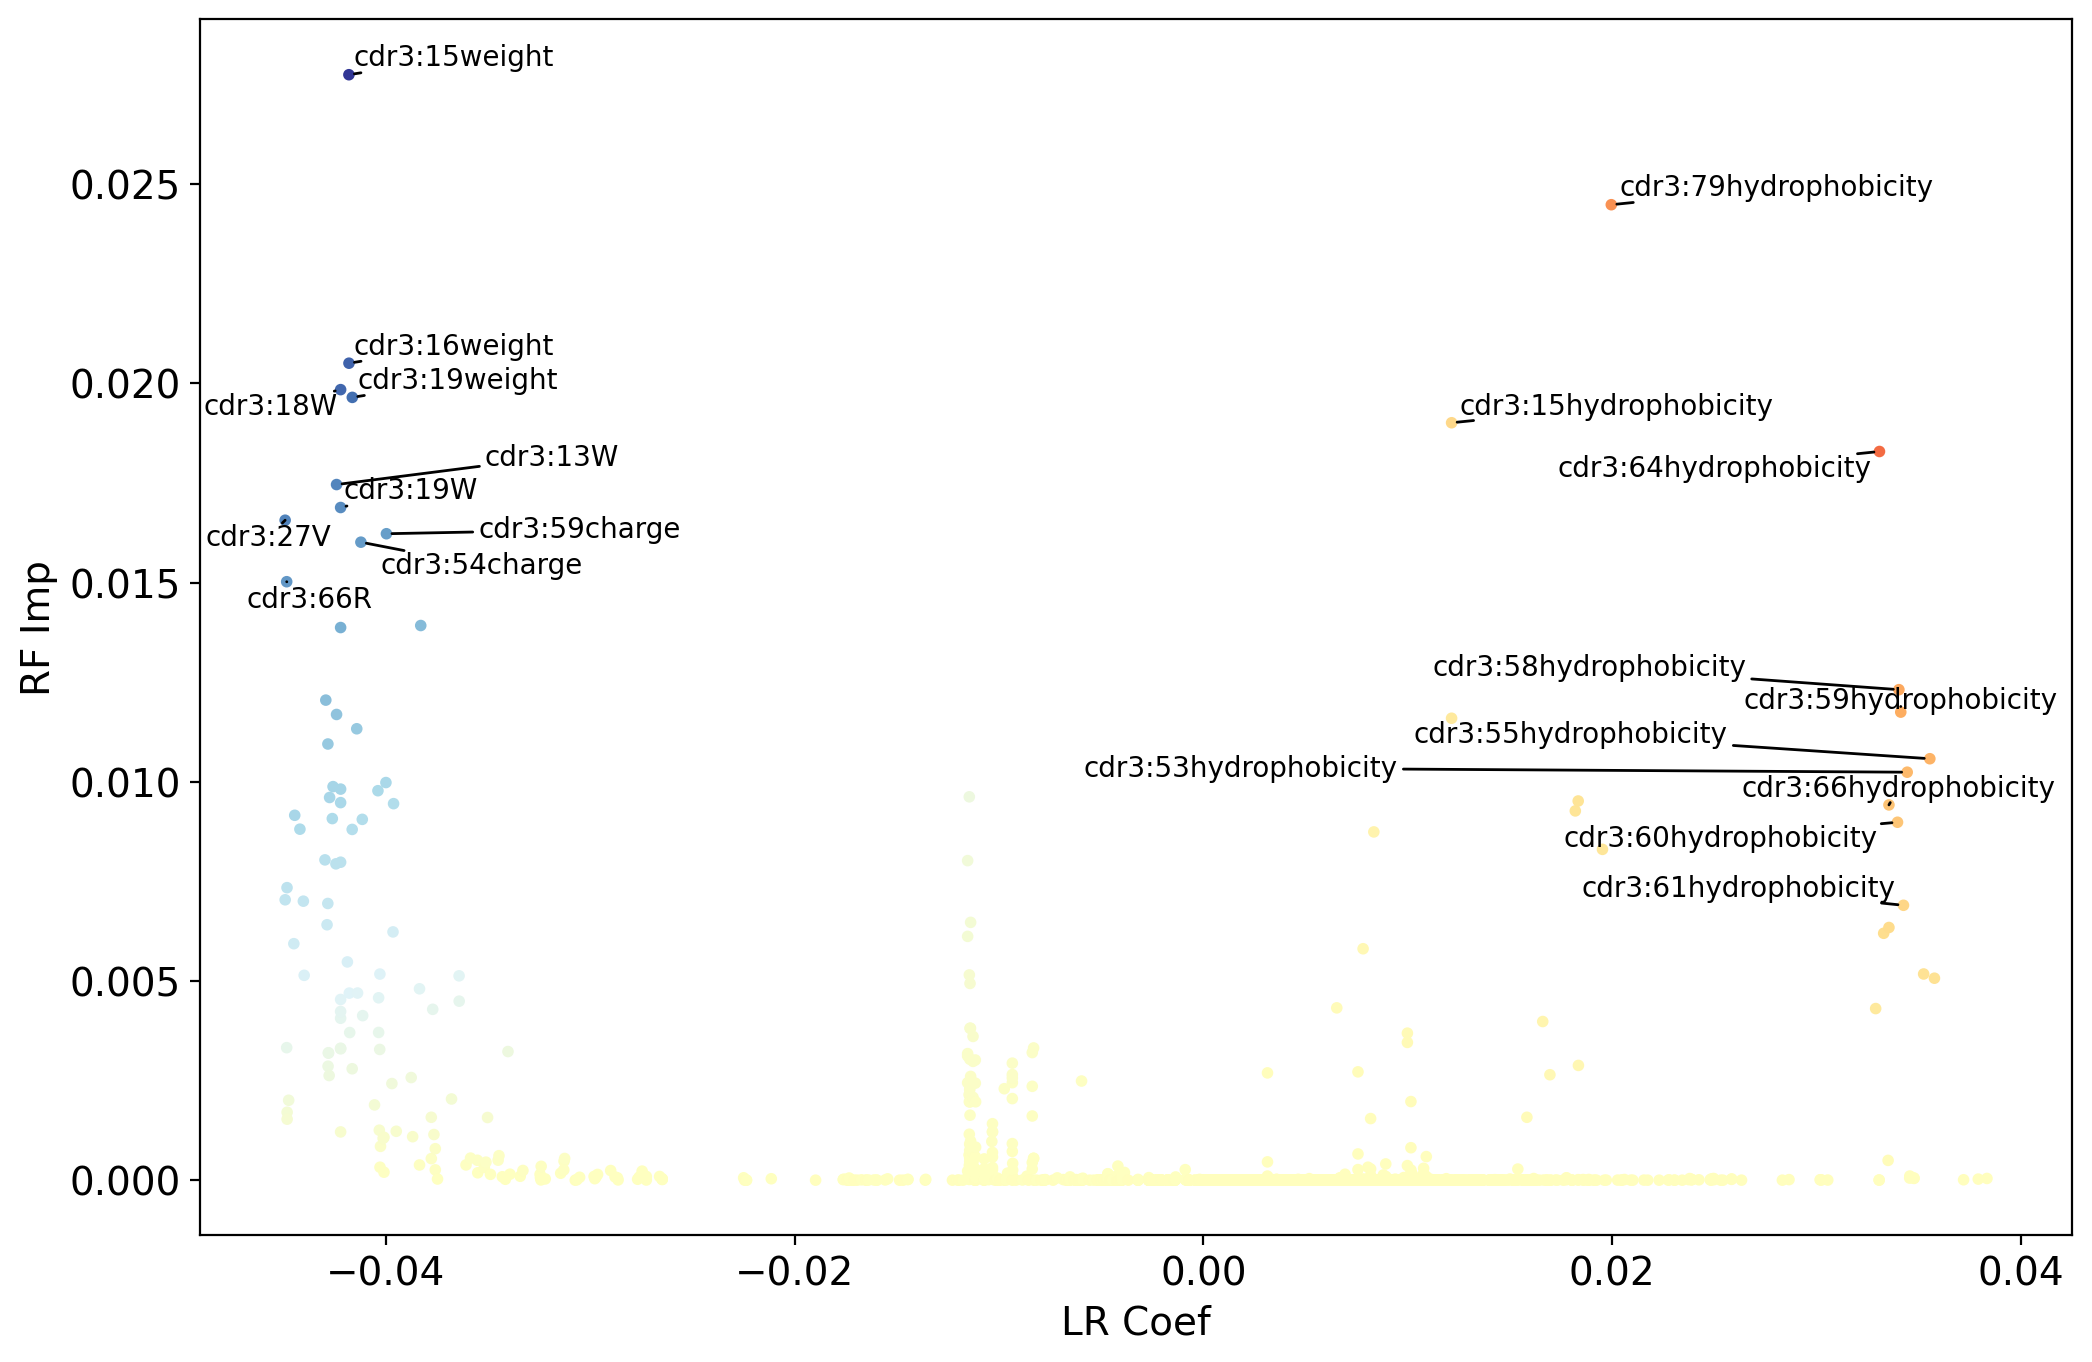

In [34]:
from adjustText import adjust_text
# plot volcano
fig, ax = plt.subplots(figsize=[12, 8])
ax.grid(False)
xs, ys = df['coef'], df['imp']
sorted_cs = (xs*ys).sort_values()
ax.scatter(xs, ys, s=10, c=xs*ys, vmin=-0.001, vmax=0.001, cmap='RdYlBu_r')
ax.set(xlabel='LR Coef', ylabel='RF Imp')
# grab the texts of interest
TEXTS = []
for idx in sorted_cs.index[:10]:
    TEXTS.append(ax.text(xs.loc[idx], ys.loc[idx], idx, fontsize=10))
for idx in sorted_cs.index[-10:]:
    TEXTS.append(ax.text(xs.loc[idx], ys.loc[idx], idx, fontsize=10))
# annotate the texts of interest
adjust_text(TEXTS, arrowprops=dict(arrowstyle="-", color='k', lw=1), ax=ax)

In [129]:
# deconstruct the variables
df[['omic','param']] = df.index.to_series().str.split(':', expand=True)

def _deconstruct(x):
    if len(x) >= 3:
        return int(x[:2])
    else:
        return int(x[0])
def deconstruct(x):
    for col in ['charge','hydrophobicity','weight','sulfur','aromatic']:
        if col in x:
            return _deconstruct(x[:-1 * (len(col) - 1)])
    return _deconstruct(x)
df['position'] = df['param'].apply(deconstruct)

def _deconstruct(x, x2):
    if len(x2) >= 3:
        return x[2:]
    else:
        return x[1:]
def deconstruct(x):
    for col in ['charge','hydrophobicity','weight','sulfur','aromatic']:
        if col in x:
            return _deconstruct(x, x[:-1 * (len(col) - 1)])
    return _deconstruct(x, x)
df['variable'] = df['param'].apply(deconstruct)

In [111]:
# get the LR, RF, and combined values
mask = df['omic'] == 'cdr3'
coef = df.loc[mask].pivot_table(index='variable', columns='position', values='coef')
imp = df.loc[mask].pivot_table(index='variable', columns='position', values='imp')
fac = (coef * 100) * (imp * 100)

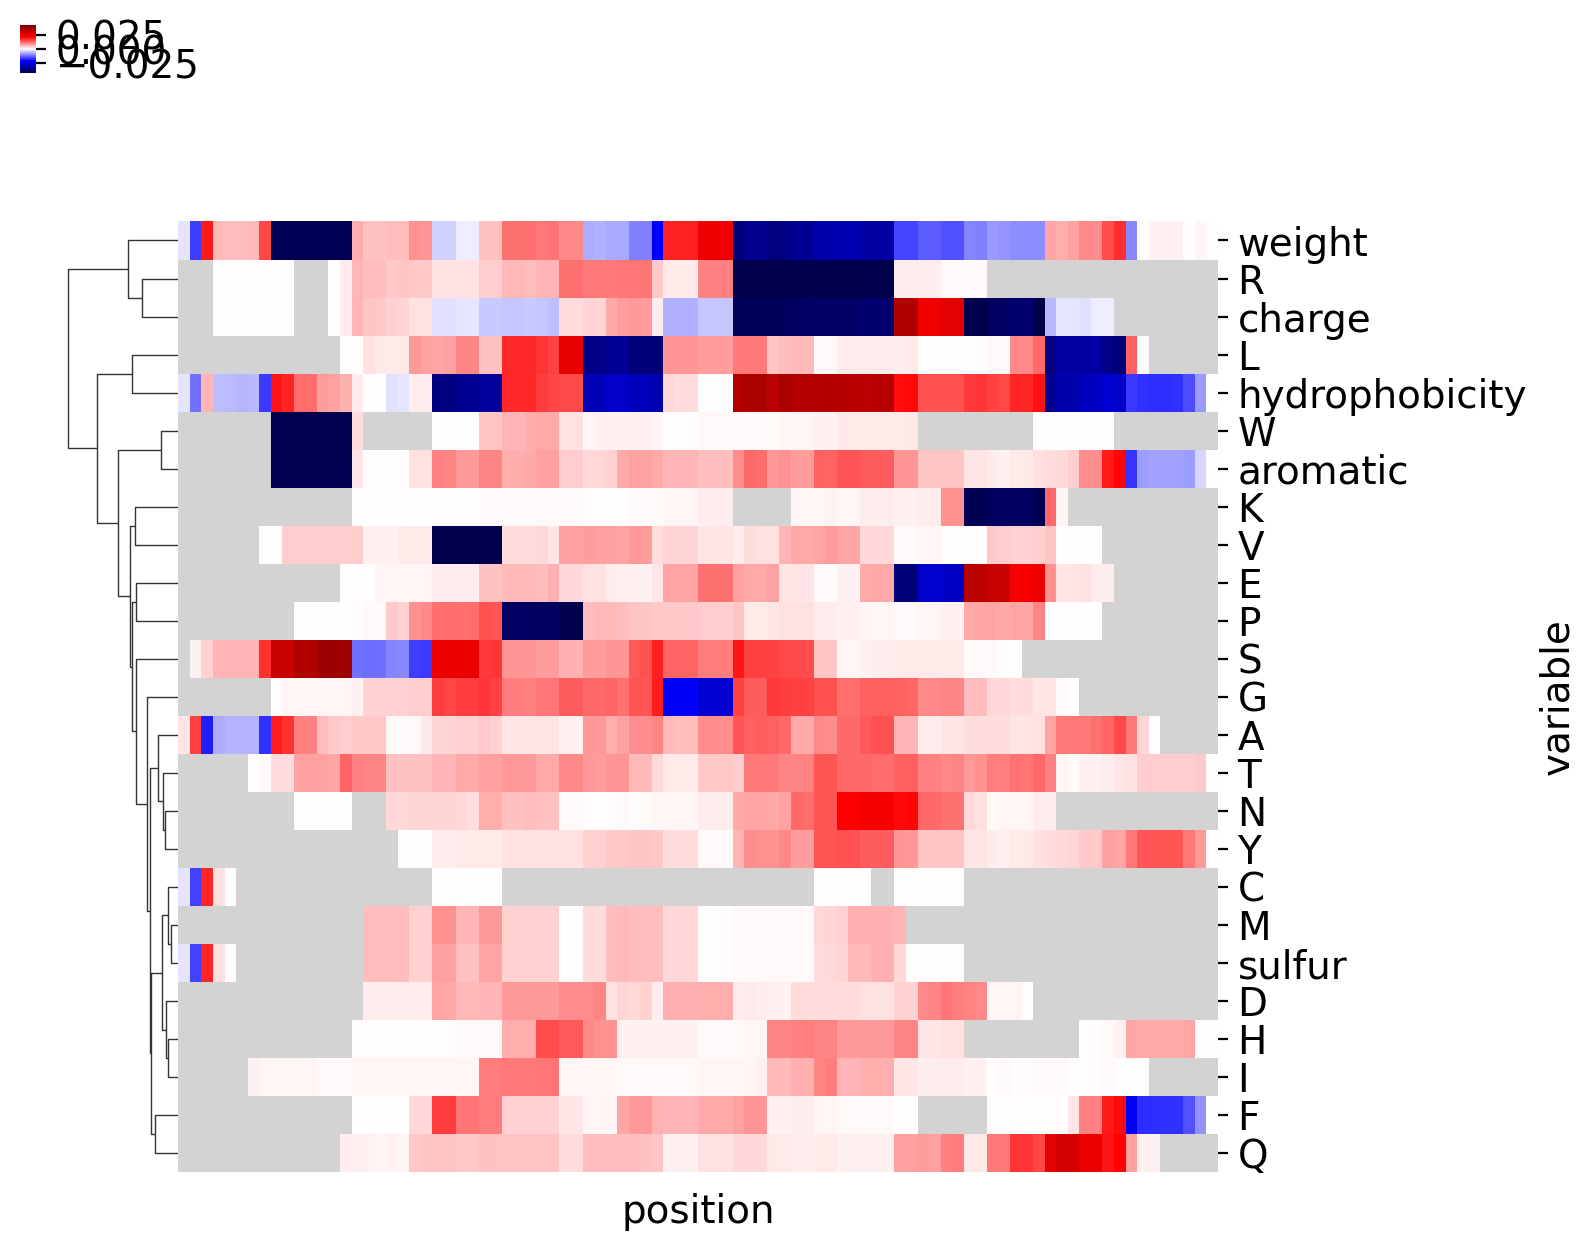

In [112]:
# now look at how they look
# > get 99th percentile
vabs = coef.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(coef.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

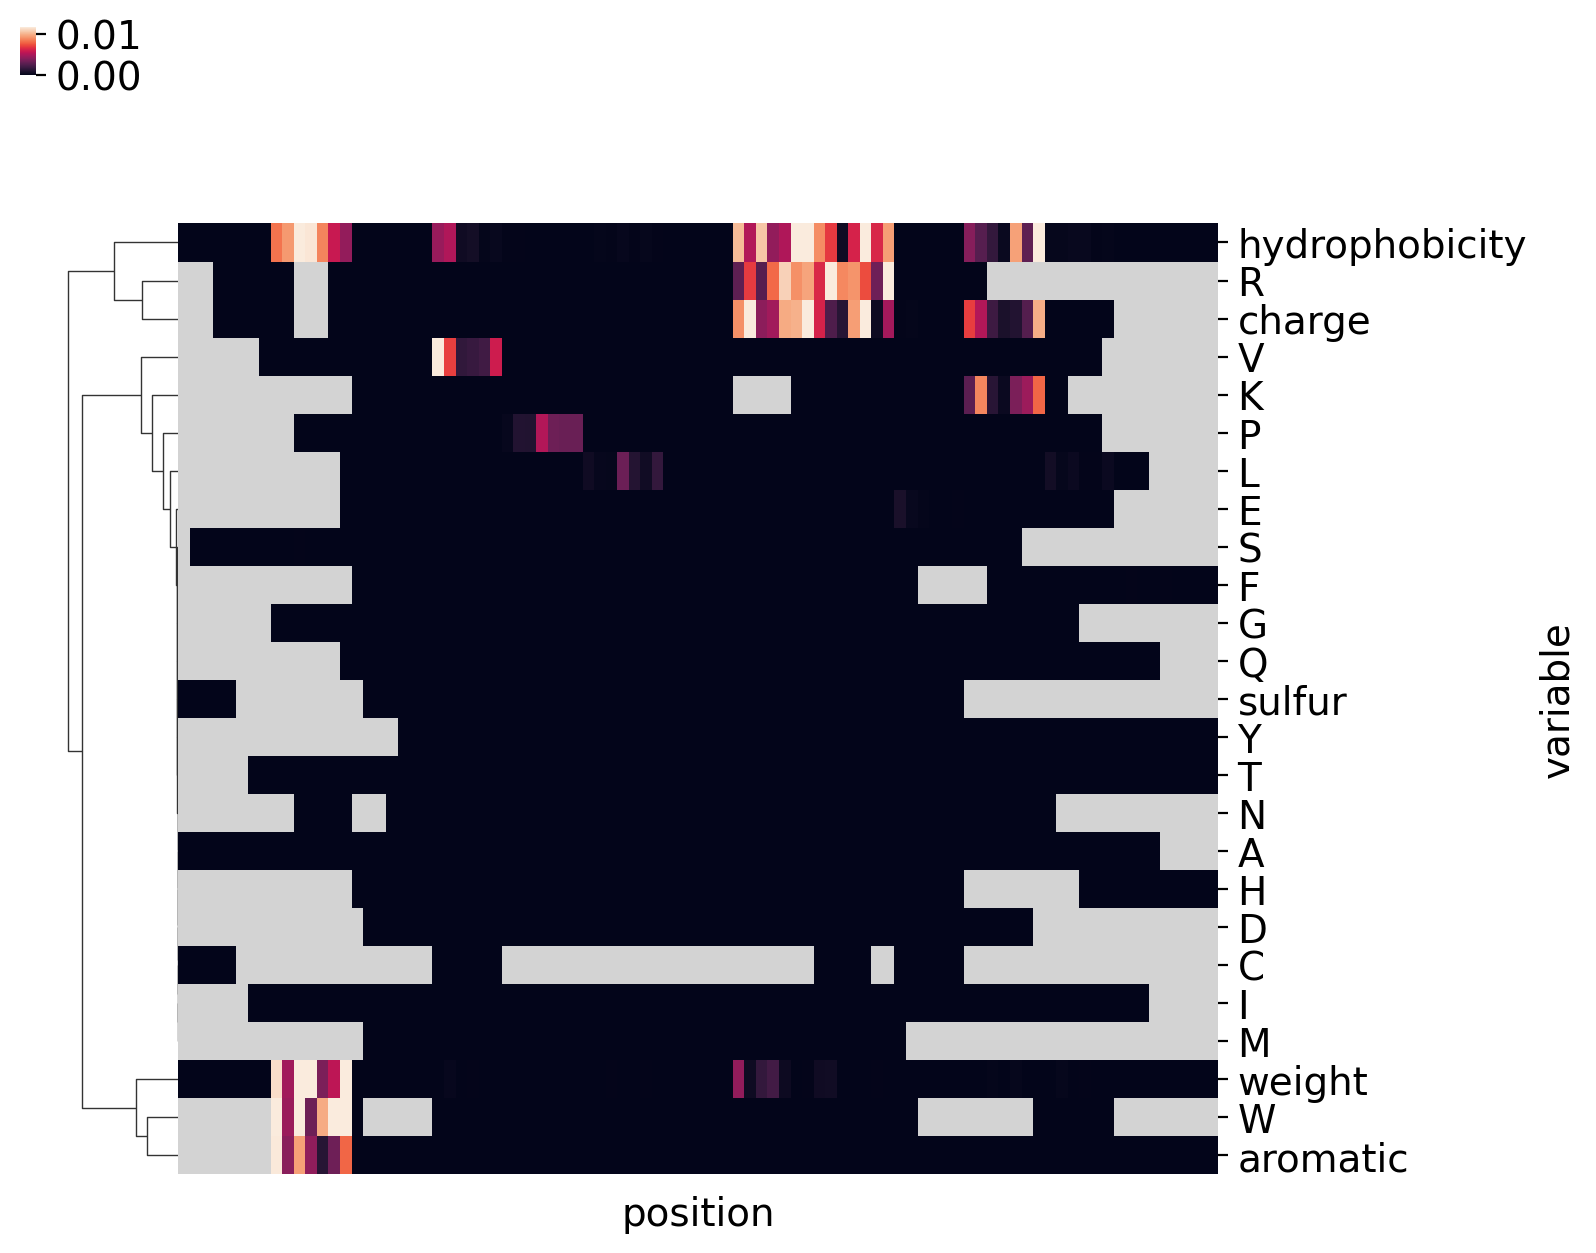

In [113]:
# now look at how they look
# > get 99th percentile
vabs = imp.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(imp.fillna(0), mask=coef.isna(), vmin=0, vmax=vabs, cmap='rocket',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

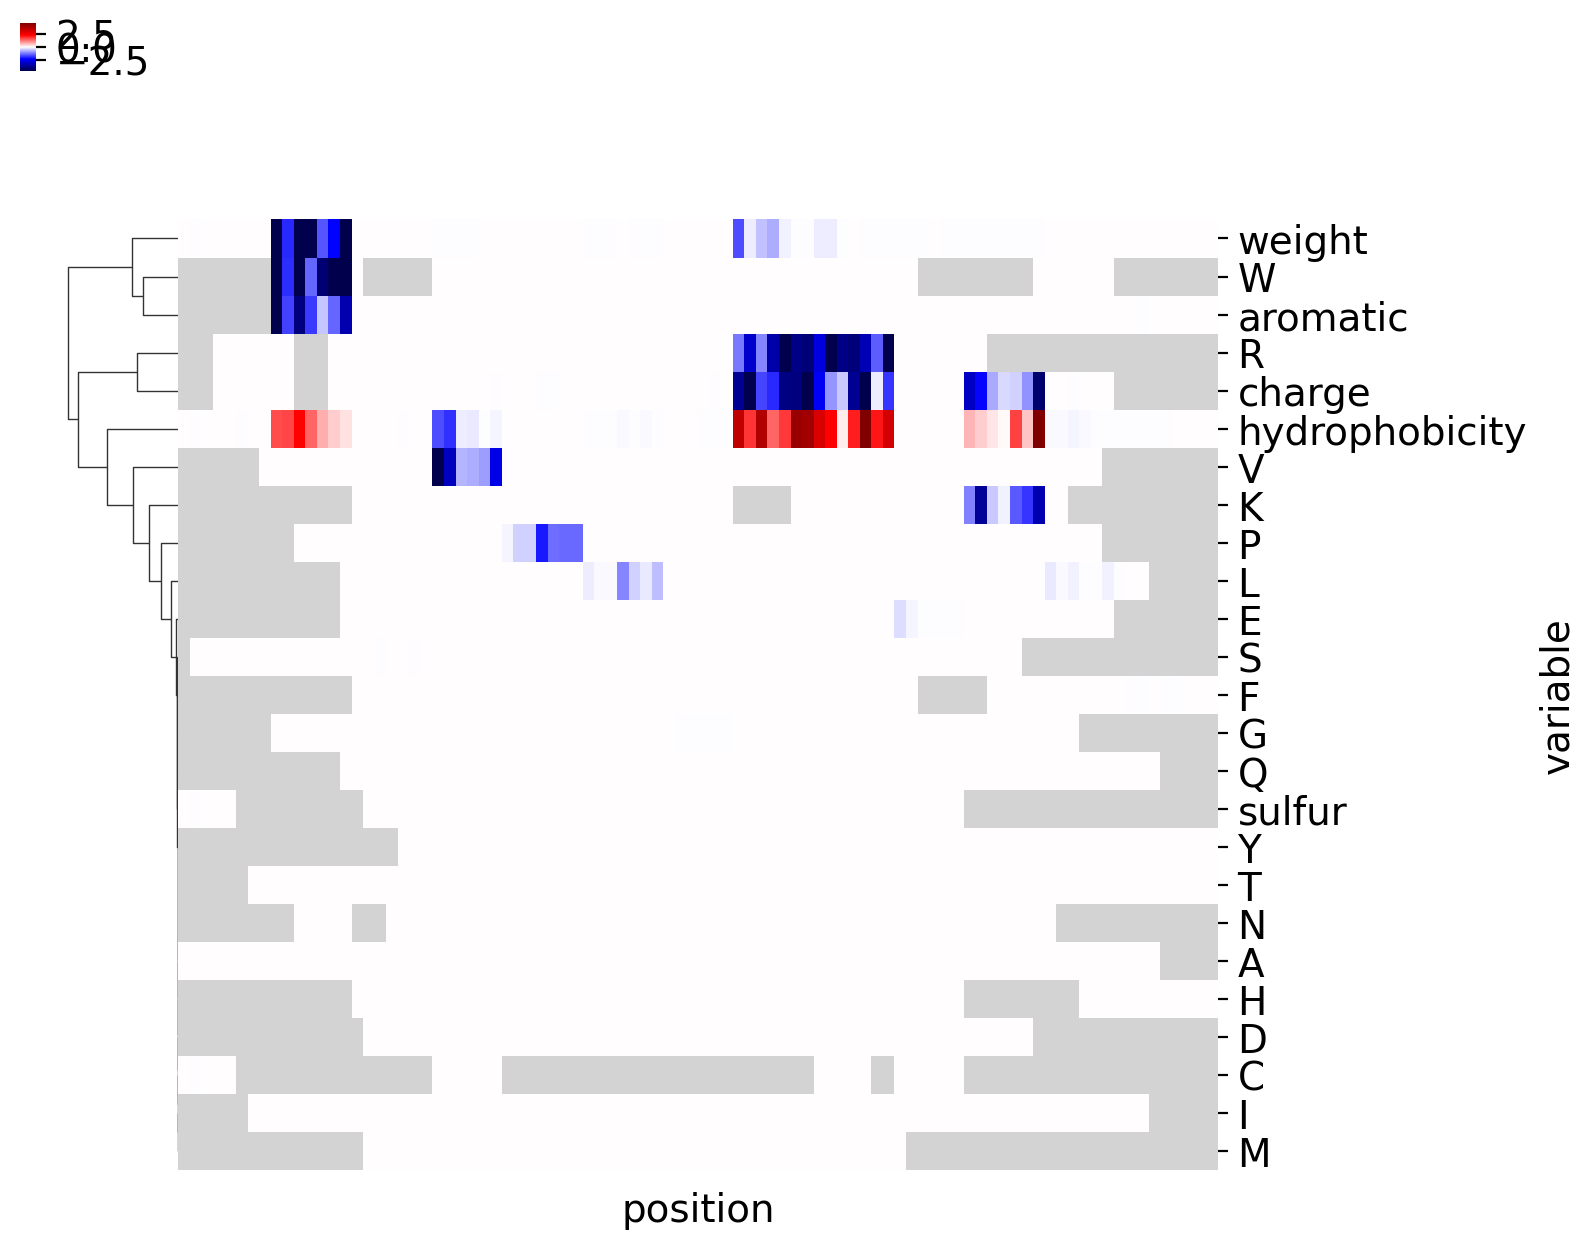

In [114]:
# now look at how they look
# > get 99th percentile
vabs = fac.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(fac.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

In [115]:
# get the LR, RF, and combined values
mask = df['omic'] == 'ag'
coef = df.loc[mask].pivot_table(index='variable', columns='position', values='coef')
imp = df.loc[mask].pivot_table(index='variable', columns='position', values='imp')
fac = (coef * 100) * (imp * 100)

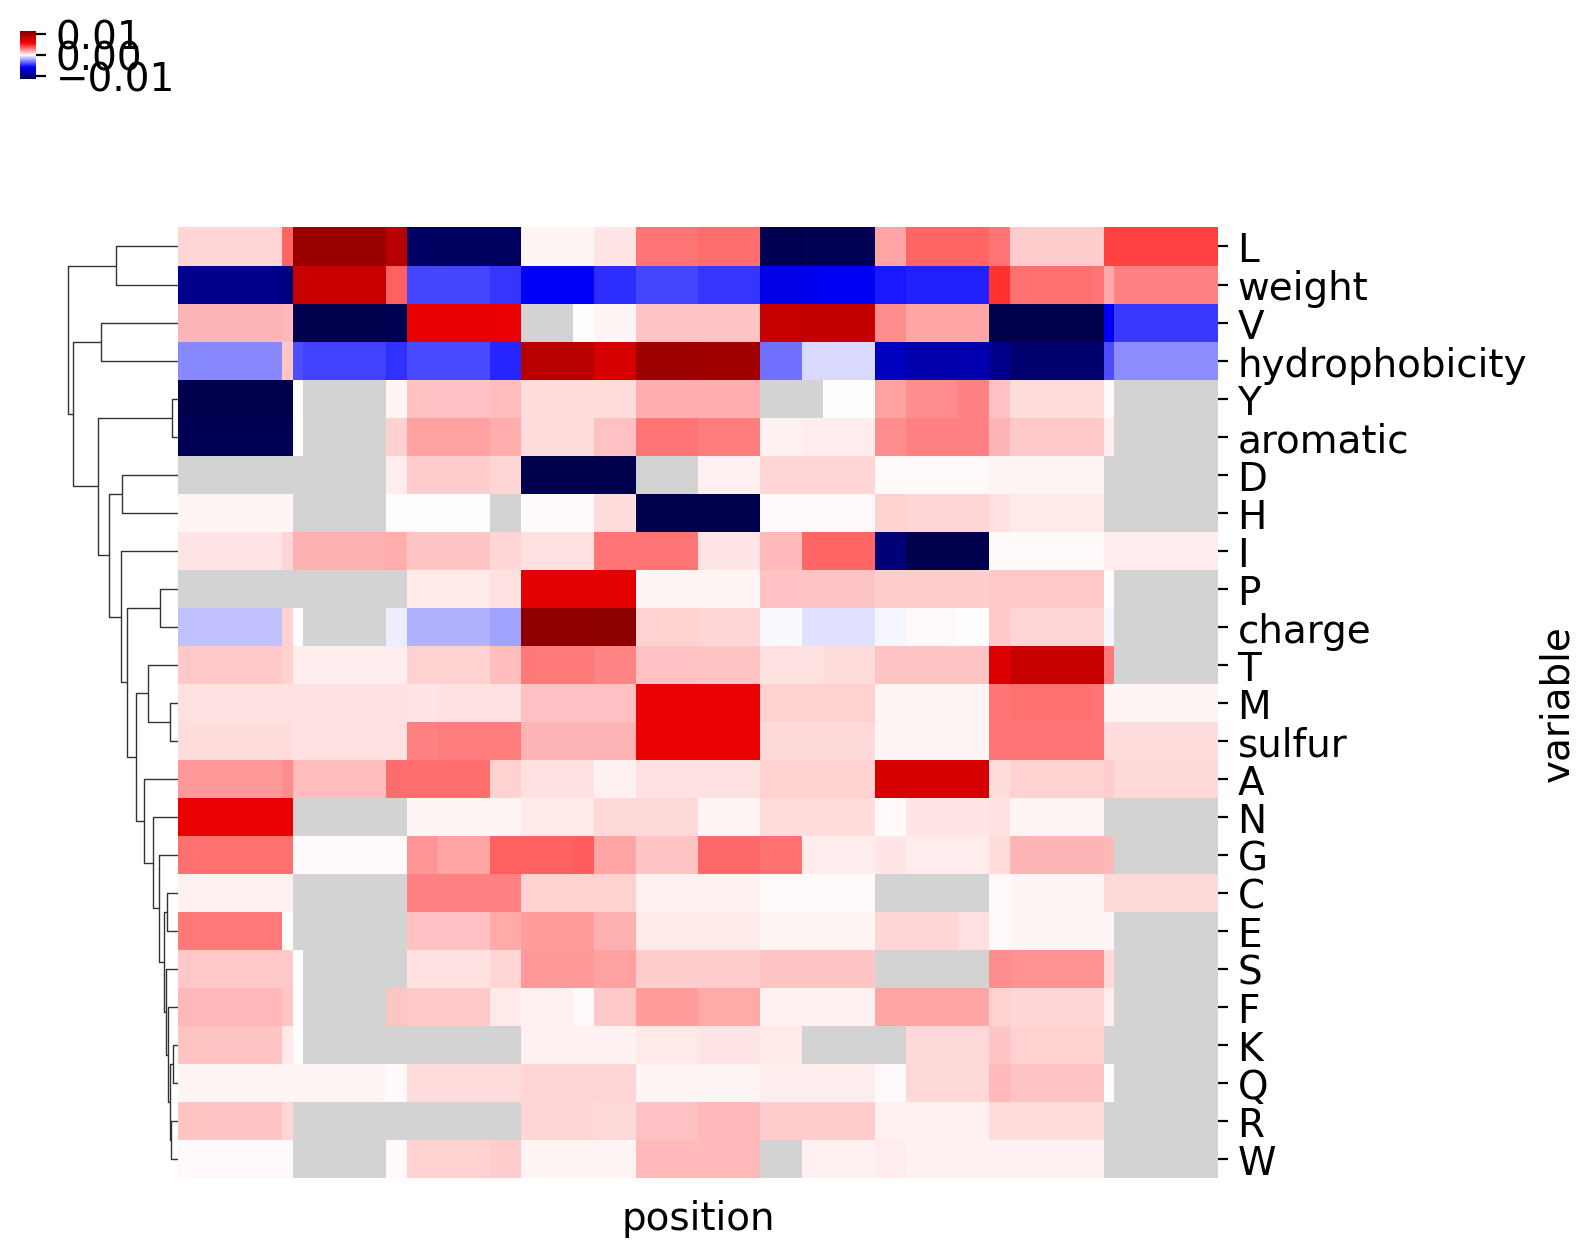

In [116]:
# now look at how they look
# > get 99th percentile
vabs = coef.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(coef.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

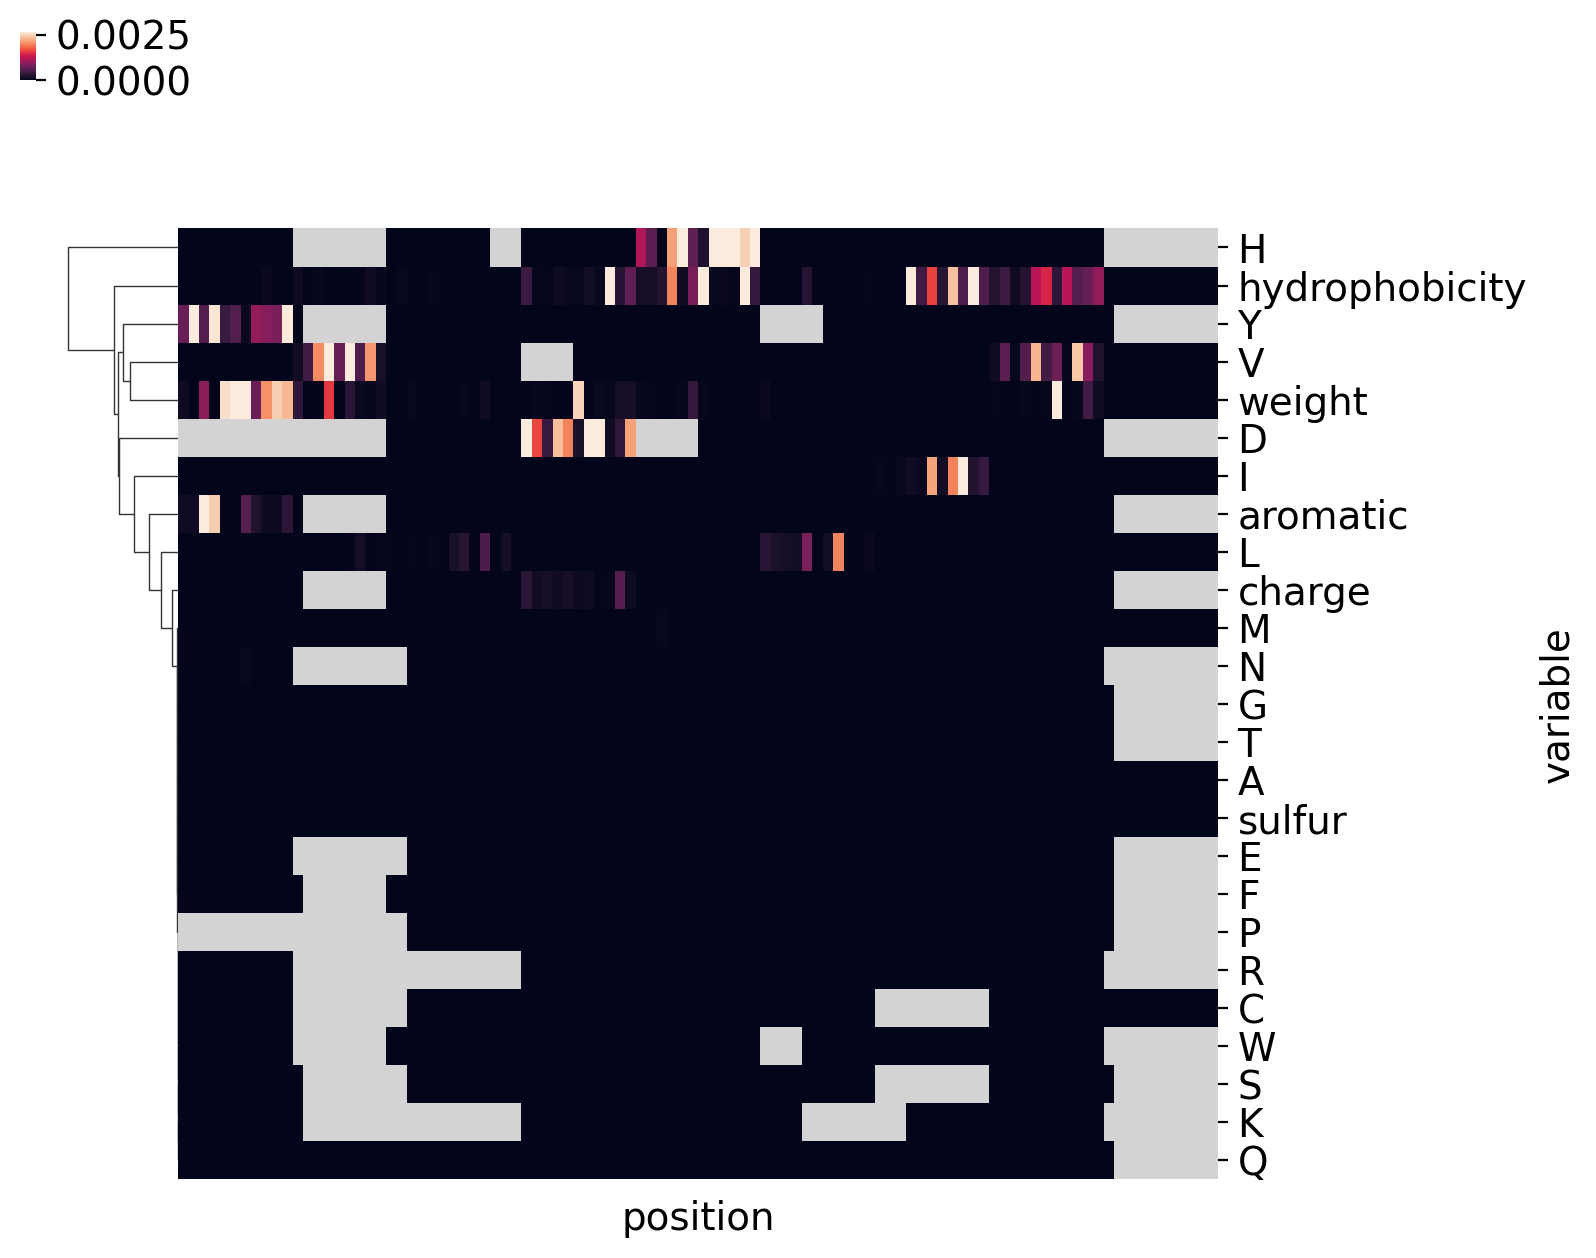

In [117]:
# now look at how they look
# > get 99th percentile
vabs = imp.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(imp.fillna(0), mask=coef.isna(), vmin=0, vmax=vabs, cmap='rocket',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

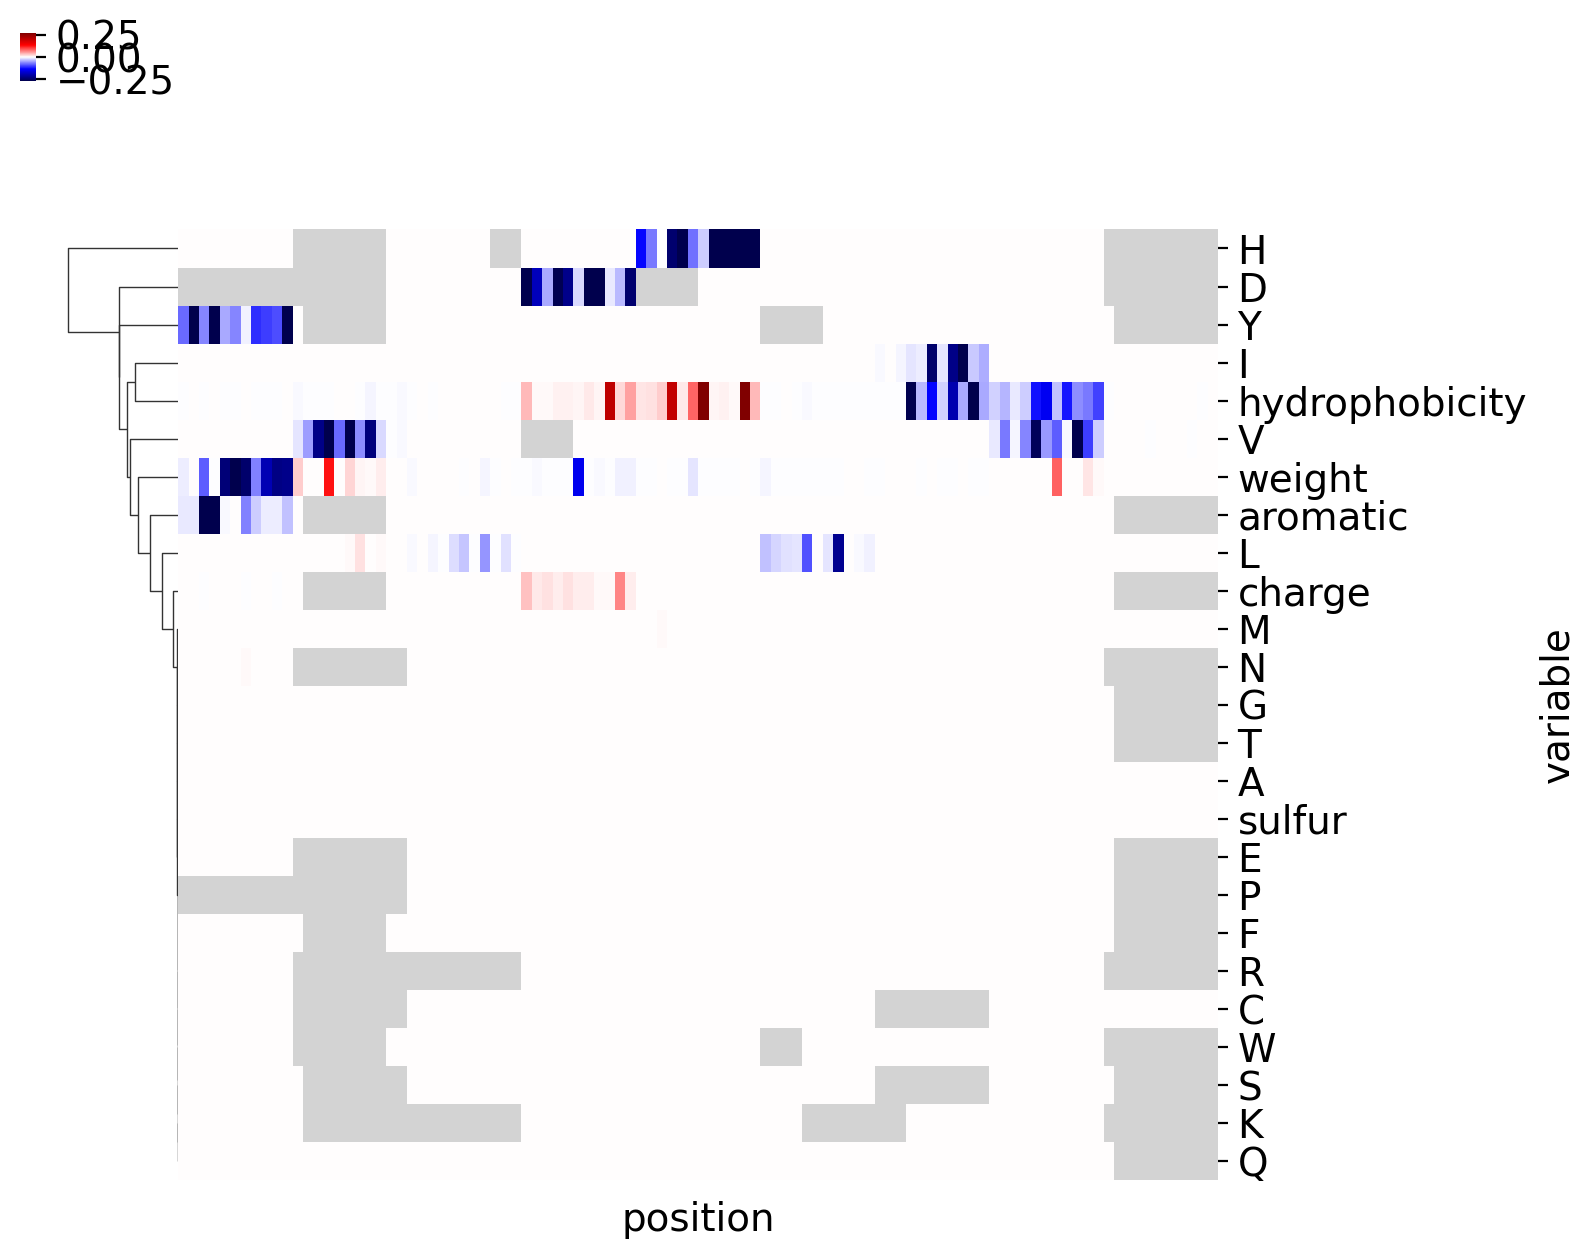

In [118]:
# now look at how they look
# > get 99th percentile
vabs = fac.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(fac.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 6], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

## subsetted model

In [127]:
# read these datasets
X = pd.read_csv('../outputs/vdjdb/trb_ag.X.csv', index_col=0)
y = pd.read_csv('../outputs/vdjdb/trb_ag.y.csv', index_col=0)['0']

In [137]:
# define the important metrics
columns = df.index[(df['imp'] >= 0.005) & (df['coef'].abs() >= 0.025)]
X = X[columns]
len(columns)

54

In [160]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []
aucs = []
probs = []
coefs = []
for idxs, idys in sss.split(X, y):
    # train on idxs
    clf = LogisticRegression(max_iter=1000, random_state=0).fit(X.iloc[idxs], y.iloc[idxs])
    # scrutinize via idys
    accs.append(clf.score(X.iloc[idys], y.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X.iloc[idys]), y.iloc[idys]))
    prob = pd.Series(clf.predict_proba(X.iloc[idys])[:, 1], index=y.iloc[idys].index)
    probs.append(prob)
    coefs.append(pd.Series(clf.coef_[0], index=clf.feature_names_in_))
    print('.', end='')

....................................................................................................

0.9995971978984238 0.0001444538907478147
0.9995985721595477 0.00014396133394456112


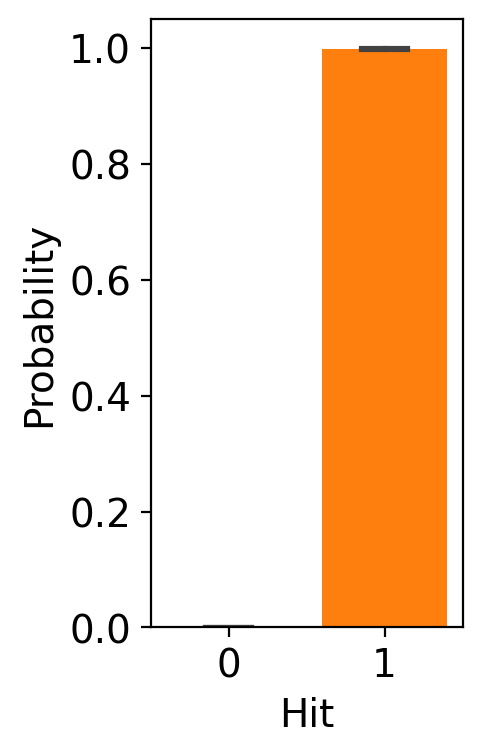

In [161]:
# retrieve probabilities
probs = pd.DataFrame(clf.predict_proba(X)[:, 1], index=y.index, columns=['Probability'])
probs['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=probs, ci=95, errwidth=1.5, capsize=0.3, saturation=1)
print(np.mean(accs), 1.96 * np.std(accs) / np.sqrt(len(accs)))
print(np.mean(aucs), 1.96 * np.std(aucs) / np.sqrt(len(aucs)))

[Text(0.5, 0, 'Rank'), Text(0, 0.5, 'Coefficient')]

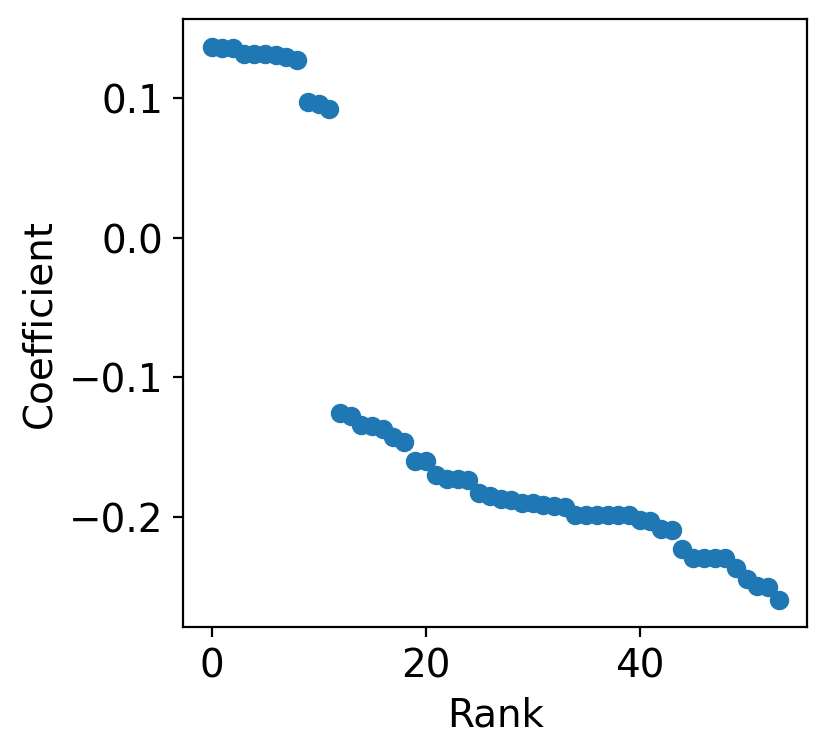

In [162]:
# average the coefficients
coef = pd.concat(coefs, axis=1).mean(1).sort_values()
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(range(coef.shape[0]), coef[::-1])
ax.set(xlabel='Rank', ylabel='Coefficient')

In [163]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []
aucs = []
probs = []
imps = []
for idxs, idys in sss.split(X, y):
    # train on idxs
    clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X.iloc[idxs], y.iloc[idxs])
    # scrutinize via idys
    accs.append(clf.score(X.iloc[idys], y.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X.iloc[idys]), y.iloc[idys]))
    imps.append(pd.Series(clf.feature_importances_, index=clf.feature_names_in_))
    prob = pd.Series(clf.predict_proba(X.iloc[idys])[:, 1], index=y.iloc[idys].index)
    probs.append(prob)
    print('.', end='')

....................................................................................................

0.9995971978984238 0.0001444538907478147
0.9995985721595477 0.00014396133394456112


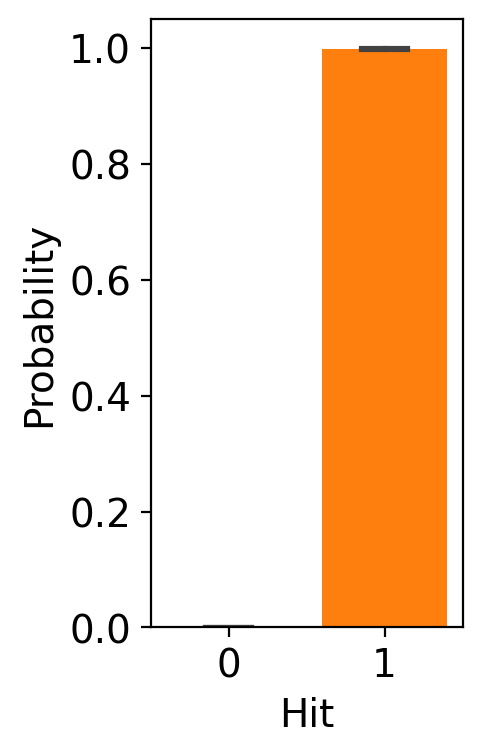

In [164]:
# retrieve probabilities
probs = pd.DataFrame(clf.predict_proba(X)[:, 1], index=y.index, columns=['Probability'])
probs['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=probs, ci=95, errwidth=1.5, capsize=0.3, saturation=1)
print(np.mean(accs), 1.96 * np.std(accs) / np.sqrt(len(accs)))
print(np.mean(aucs), 1.96 * np.std(aucs) / np.sqrt(len(aucs)))

[Text(0.5, 0, 'Rank'), Text(0, 0.5, 'Importance')]

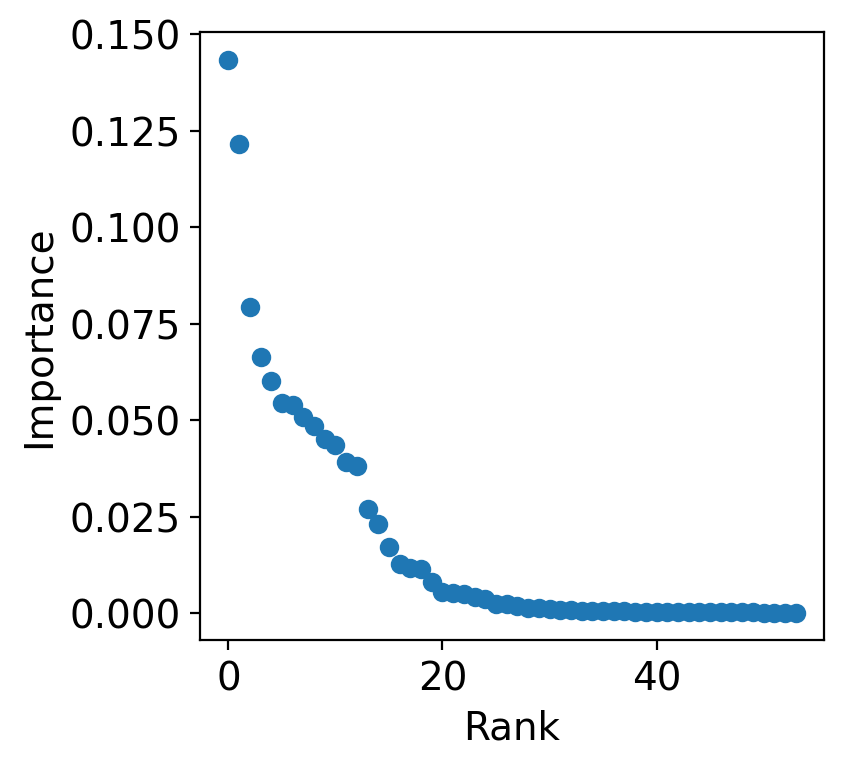

In [165]:
# now compute the importances
imp = pd.concat(imps, axis=1).mean(1).sort_values()
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(range(imp.shape[0]), imp[::-1])
ax.set(xlabel='Rank', ylabel='Importance')

In [166]:
# save the variable
coef.name = 'coef'
imp.name = 'imp'
df = pd.DataFrame(coef).join(imp)

209

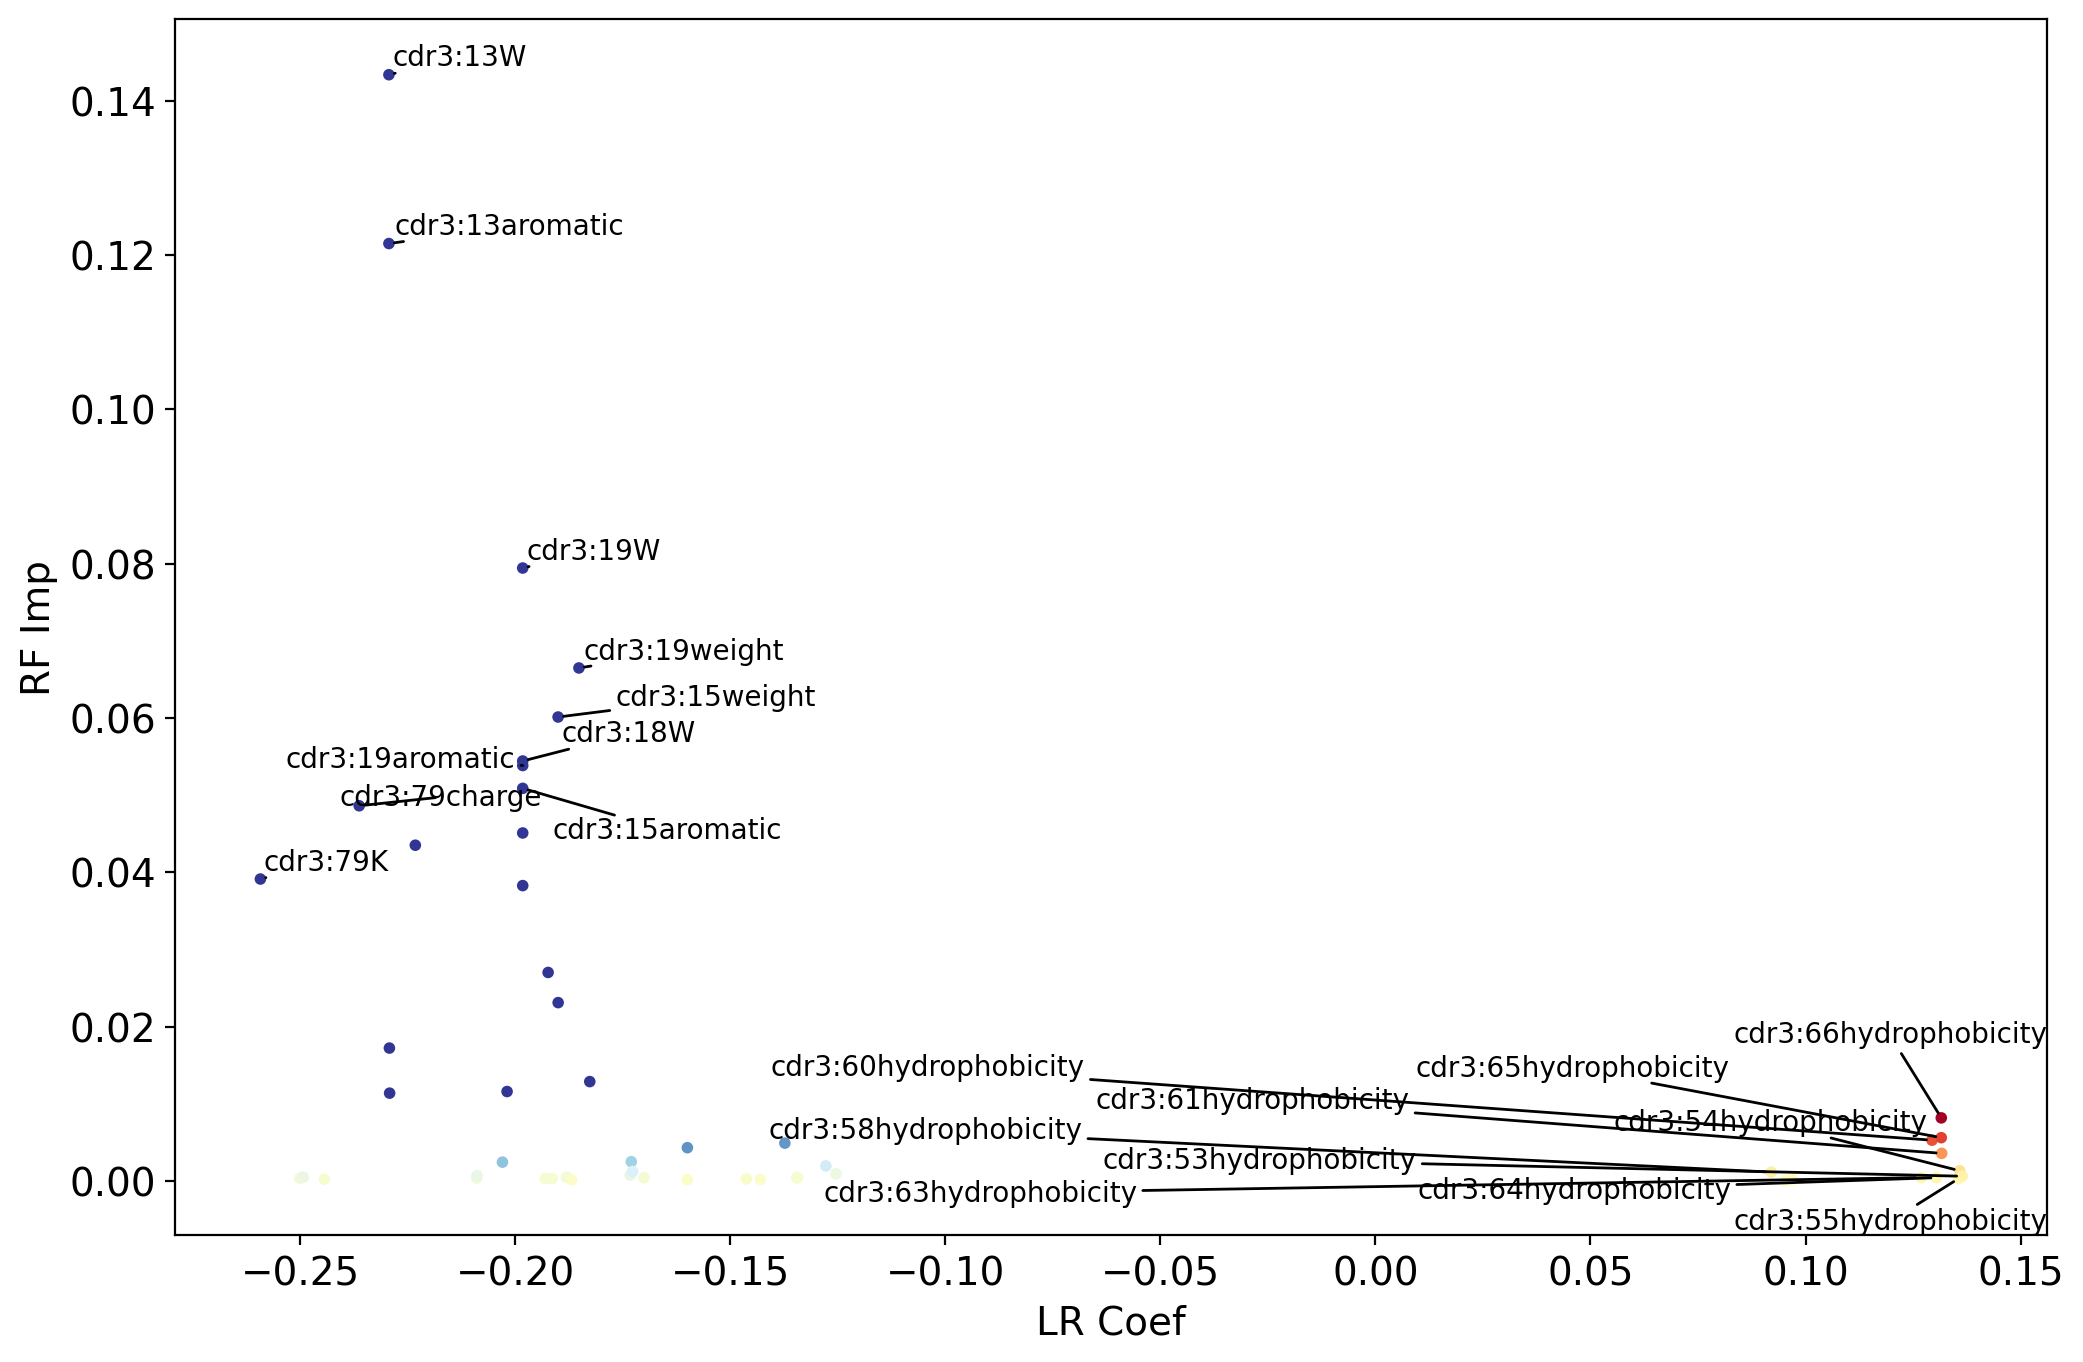

In [167]:
from adjustText import adjust_text
# plot volcano
fig, ax = plt.subplots(figsize=[12, 8])
ax.grid(False)
xs, ys = df['coef'], df['imp']
sorted_cs = (xs*ys).sort_values()
ax.scatter(xs, ys, s=10, c=xs*ys, vmin=-0.001, vmax=0.001, cmap='RdYlBu_r')
ax.set(xlabel='LR Coef', ylabel='RF Imp')
# grab the texts of interest
TEXTS = []
for idx in sorted_cs.index[:10]:
    TEXTS.append(ax.text(xs.loc[idx], ys.loc[idx], idx, fontsize=10))
for idx in sorted_cs.index[-10:]:
    TEXTS.append(ax.text(xs.loc[idx], ys.loc[idx], idx, fontsize=10))
# annotate the texts of interest
adjust_text(TEXTS, arrowprops=dict(arrowstyle="-", color='k', lw=1), ax=ax)

In [168]:
# deconstruct the variables
df[['omic','param']] = df.index.to_series().str.split(':', expand=True)

def _deconstruct(x):
    if len(x) >= 3:
        return int(x[:2])
    else:
        return int(x[0])
def deconstruct(x):
    for col in ['charge','hydrophobicity','weight','sulfur','aromatic']:
        if col in x:
            return _deconstruct(x[:-1 * (len(col) - 1)])
    return _deconstruct(x)
df['position'] = df['param'].apply(deconstruct)

def _deconstruct(x, x2):
    if len(x2) >= 3:
        return x[2:]
    else:
        return x[1:]
def deconstruct(x):
    for col in ['charge','hydrophobicity','weight','sulfur','aromatic']:
        if col in x:
            return _deconstruct(x, x[:-1 * (len(col) - 1)])
    return _deconstruct(x, x)
df['variable'] = df['param'].apply(deconstruct)

In [169]:
# get the LR, RF, and combined values
mask = df['omic'] == 'cdr3'
coef = df.loc[mask].pivot_table(index='variable', columns='position', values='coef')
imp = df.loc[mask].pivot_table(index='variable', columns='position', values='imp')
fac = (coef * 100) * (imp * 100)

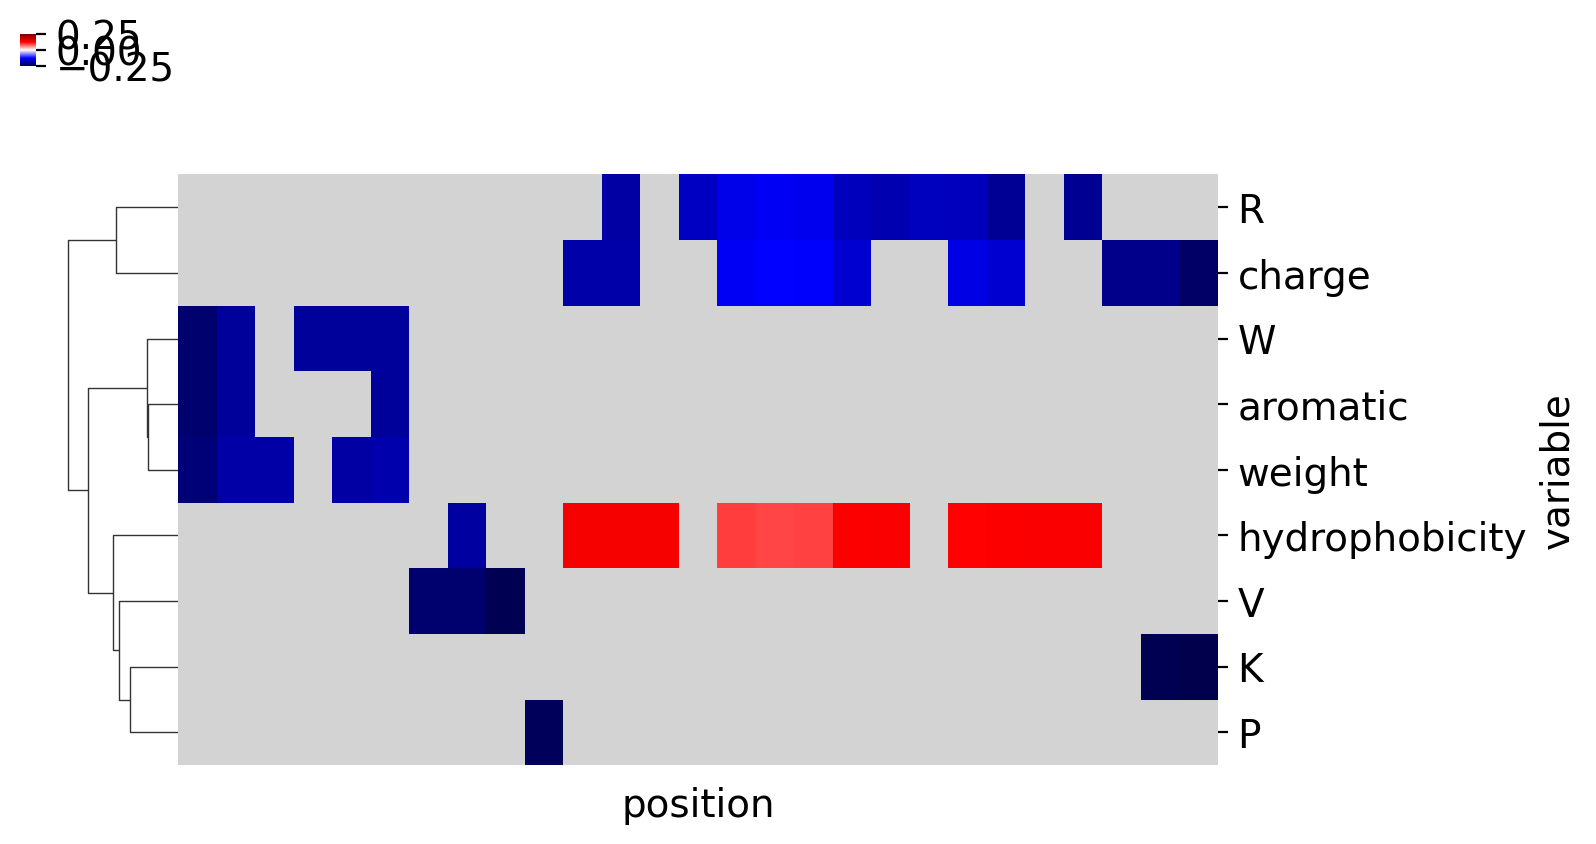

In [170]:
# now look at how they look
# > get 99th percentile
vabs = coef.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(coef.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 4], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

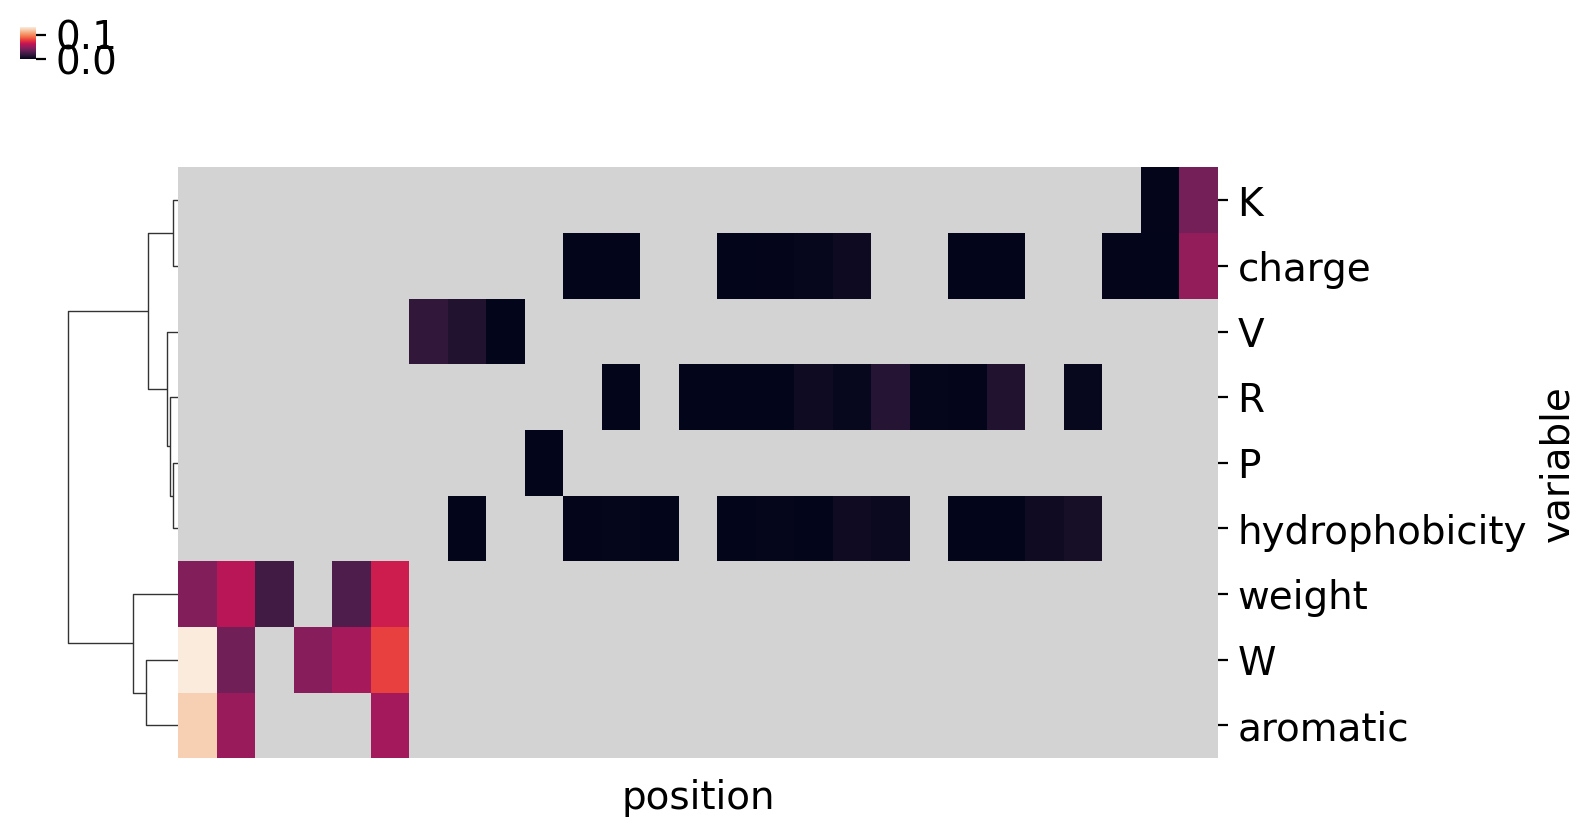

In [171]:
# now look at how they look
# > get 99th percentile
vabs = imp.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(imp.fillna(0), mask=coef.isna(), vmin=0, vmax=vabs, cmap='rocket',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 4], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

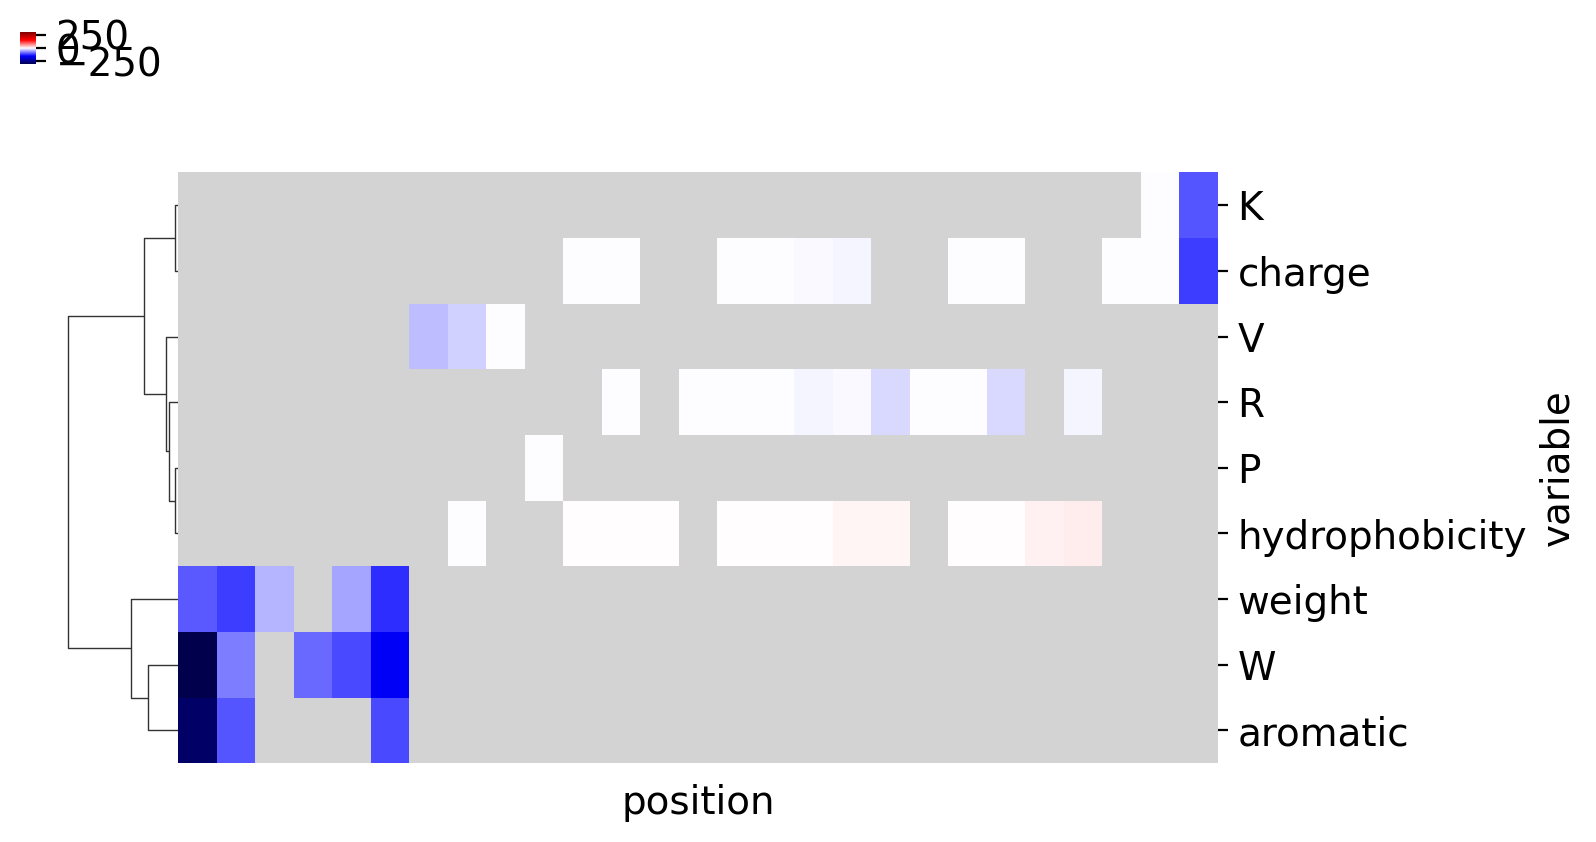

In [172]:
# now look at how they look
# > get 99th percentile
vabs = fac.astype(float).abs().values.flatten()
vabs = np.percentile(vabs[~np.isnan(vabs)], 99)
# then make the acutla plot
g = sns.clustermap(fac.fillna(0), mask=coef.isna(), vmin=-vabs, vmax=vabs, cmap='seismic',
                   col_cluster=False, row_cluster=True, method='ward', dendrogram_ratio=.1,
                   cbar_pos=(0, 1, .01, .04), figsize=[8, 4], xticklabels=0, yticklabels=1)
g.ax_heatmap.set_facecolor('lightgray')

In [173]:
# save the values for inferences
X_train, y_train = X.copy(), y.copy()

In [245]:
# load in the IEDB data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/iedb.receptor_table_export_1692393367.csv', index_col=0)
df = df.reset_index().iloc[:, 1:]

In [246]:
# filter only for the beta sequences
df = df.loc[df['Chain 2 - Type'] == 'beta']
df = df.dropna(subset=['Chain 2 - CDR3 Curated'])
df = df[['Chain 2 - CDR3 Curated', 'Epitope - Name']]
df.columns = ['CDR3','Epitope']

# choose random subset of 1000
np.random.seed(0)
df = df.reset_index().iloc[:, 1:]
df = df.loc[np.random.choice(df.index, size=1000, replace=False)]
df = df.reset_index().iloc[:, 1:]

In [247]:
from tqdm import tqdm
# the first step is the interpolation of nucleotide
alphabet = sorted(set([el for x in df['CDR3'] for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_cdr3s = pd.DataFrame(index=range(df.shape[0]), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for pep_idx in tqdm(X_cdr3s.index):
    # grab peptide
    peptide = df['CDR3'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_cdr3s.loc[pep_idx] = X.values.flatten()

100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.84it/s]


In [248]:
# this second step is repeating the same thing but for the peptides
alphabet = sorted(set([el for x in df['Epitope'] for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_epitopes = pd.DataFrame(index=range(df.shape[0]), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for pep_idx in tqdm(X_epitopes.index):
    # grab peptide
    peptide = df['Epitope'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_epitopes.loc[pep_idx] = X.values.flatten()

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.03it/s]


In [249]:
# define y
y = pd.Series(1, index=X_cdr3s.index)

In [250]:
# join together the two dataframes
X_cdr3s.columns = 'cdr3:' + X_cdr3s.columns
X_epitopes.columns = 'ag:' + X_epitopes.columns

In [254]:
# now we need to add a few control elements
# for each given peptide, i want to randomly select TCRs that do not bind to it of equal number
np.random.seed(0)
for _, (epitope, n_tcrs) in tqdm(df['Epitope'].value_counts().reset_index().iterrows()):
    # grab peptide
    peptide = df['Epitope'].iloc[pep_idx]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet_epitope] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_epitope = X.values.flatten()
    
    # make sure we are not getting this epitope nor cdr3s known to bind to this epitope
    mask = df['Epitope'] != epitope
    cdr3s_epitope = df.loc[df['Epitope'] == epitope, 'CDR3'].unique()
    mask = mask & (~df['CDR3'].isin(cdr3s_epitope))
    
    # now lets select with replacement the other ones
    cdr3s = np.random.choice(df.loc[mask, 'CDR3'], size=n_tcrs, replace=True)
    
    for cdr3 in cdr3s:
        # grab peptide
        peptide = df['CDR3'].iloc[pep_idx]
        # create the tracking dataframe
        X = pd.DataFrame(np.nan, index=range(100), columns=columns)
        step = 100 / len(peptide)
        for idx, aa in enumerate(peptide):
            # find start and end of each peptide
            start, end = round(idx * step), round((idx + 1) * step)
            if idx == len(peptide) - 1:
                end = 100
            # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
            charge = amino_acid_charge[aa]
            hydrophobicity = amino_acid_hydrophobicity[aa] / 2
            weight = amino_acid_weights[aa] / 100
            sulfur = 1 * (aa in has_sulfur)
            aromatic = 1 * (aa in is_aromatic)
            X.loc[start:end, alphabet_cdr3] = 0
            X.loc[start:end, aa] = 1
            X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
        assert not X.isna().any().any()
        X_cdr3 = X.values.flatten()
        # append
        X_cdr3s.loc[X_cdr3s.shape[0]] = X_cdr3
        X_epitopes.loc[X_epitopes.shape[0]] = X_epitope
        y.loc[y.shape[0]] = 0

177it [05:11,  1.76s/it]


In [255]:
# rejoin these dataframes together
X = X_cdr3s.join(X_epitopes)

# grab the relevant data
X = X[X_train.columns]

# normalize
means = pd.read_csv('../outputs/vdjdb/model_v2.means.csv', index_col=0).iloc[:, 0].loc[X.columns]
stds = pd.read_csv('../outputs/vdjdb/model_v2.stds.csv', index_col=0).iloc[:, 0].loc[X.columns]
X -= means
X /= stds

In [256]:
# write this validation set
X.to_csv('../outputs/iedb/model_v2.val.X.csv')
y.to_csv('../outputs/iedb/model_v2.val.y.csv')

In [262]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []; accs_new = []
aucs = []; aucs_new = []
probs = []; probs_new = []
for idxs, idys in sss.split(X_train, y_train):
    # train on idxs of the training dataset
    clf = LogisticRegression(max_iter=1000, random_state=0).fit(X_train.iloc[idxs], y_train.iloc[idxs])
    # scrutinize via the idys of the training dataset
    accs.append(clf.score(X_train.iloc[idys], y_train.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X_train.iloc[idys]), y_train.iloc[idys]))
    prob = pd.Series(clf.predict_proba(X_train.iloc[idys])[:, 1], index=y_train.iloc[idys].index)
    probs.append(prob)
    # scrutinize via the complete new dataset
    accs_new.append(clf.score(X, y))
#     aucs_new.append(roc_auc_score(clf.predict(X), y))
    prob = pd.Series(clf.predict_proba(X)[:, 1], index=y.index)
    probs_new.append(prob)
    print('.', end='')

....................................................................................................

TEST acc 0.9995971978984238 0.0001444538907478147
TEST auc 0.9995985721595477 0.00014396133394456112

VAL acc 0.5 0.0



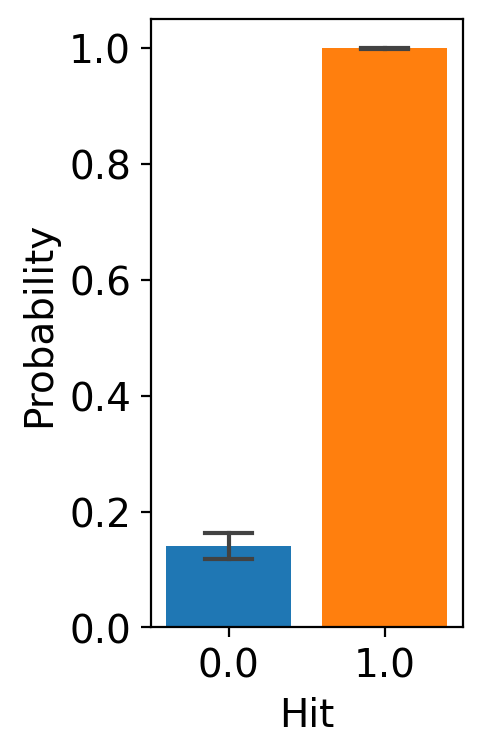

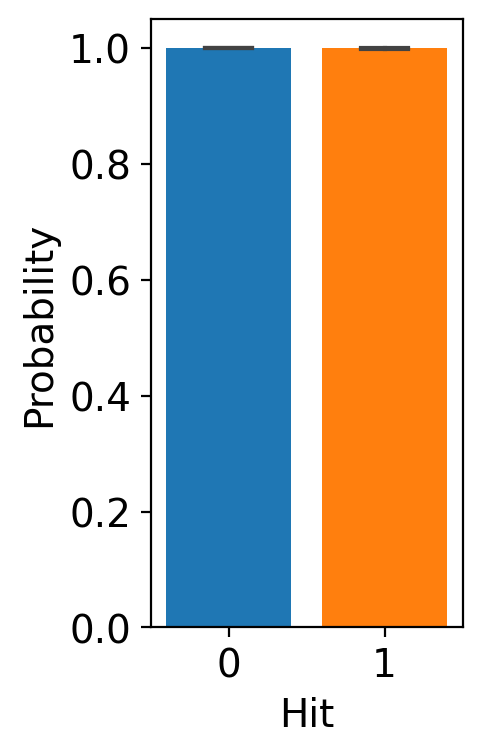

In [265]:
# retrieve probabilities
prob = pd.concat(probs, axis=1).mean(1).reset_index()
prob.columns = ['index','Probability']
prob['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=prob, ci=95, errwidth=1.5, capsize=0.3, saturation=1)

print('TEST acc', np.mean(accs), 1.96 * np.std(accs) / np.sqrt(len(accs)))
print('TEST auc', np.mean(aucs), 1.96 * np.std(aucs) / np.sqrt(len(aucs)))
print()

# retrieve probabilities
prob = pd.concat(probs_new, axis=1).mean(1).reset_index()
prob.columns = ['index','Probability']
prob['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=prob, ci=95, errwidth=1.5, capsize=0.3, saturation=1)

print('VAL acc', np.mean(accs_new), 1.96 * np.std(accs_new) / np.sqrt(len(accs_new)))
# print('VAL auc', np.mean(aucs_new), 1.96 * np.std(aucs_new) / np.sqrt(len(aucs_new)))
print()

In [267]:
# now let's create the logit model
np.random.seed(0)
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
accs = []; accs_new = []
aucs = []; aucs_new = []
probs = []; probs_new = []
for idxs, idys in sss.split(X_train, y_train):
    # train on idxs of the training dataset
    clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train.iloc[idxs], y_train.iloc[idxs])
    # scrutinize via the idys of the training dataset
    accs.append(clf.score(X_train.iloc[idys], y_train.iloc[idys]))
    aucs.append(roc_auc_score(clf.predict(X_train.iloc[idys]), y_train.iloc[idys]))
    prob = pd.Series(clf.predict_proba(X_train.iloc[idys])[:, 1], index=y_train.iloc[idys].index)
    probs.append(prob)
    # scrutinize via the complete new dataset
    accs_new.append(clf.score(X, y))
#     aucs_new.append(roc_auc_score(clf.predict(X), y))
    prob = pd.Series(clf.predict_proba(X)[:, 1], index=y.index)
    probs_new.append(prob)
    print('.', end='')

....................................................................................................

TEST acc 0.9995971978984238 0.0001444538907478147
TEST auc 0.9995985721595477 0.00014396133394456112

VAL acc 0.5 0.0



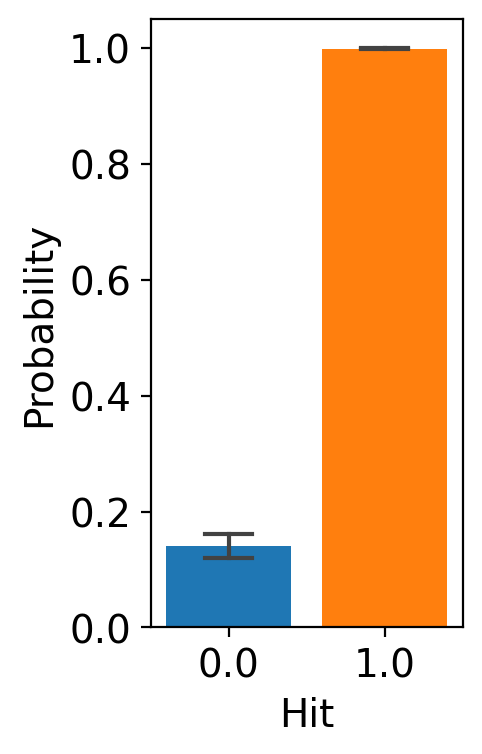

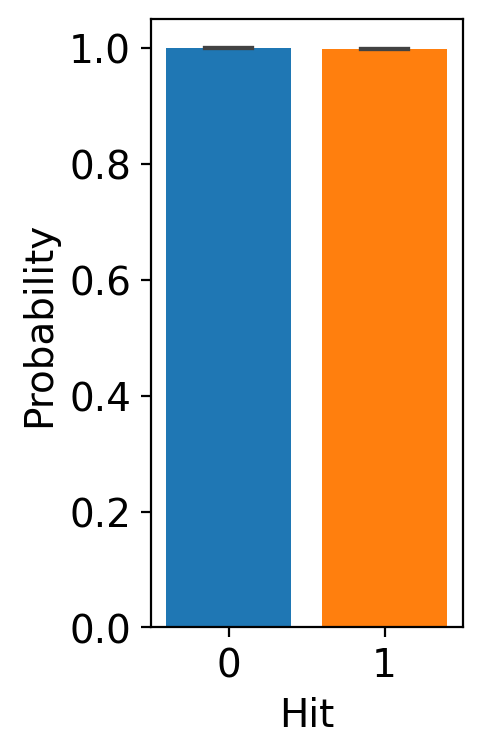

In [268]:
# retrieve probabilities
prob = pd.concat(probs, axis=1).mean(1).reset_index()
prob.columns = ['index','Probability']
prob['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=prob, ci=95, errwidth=1.5, capsize=0.3, saturation=1)

print('TEST acc', np.mean(accs), 1.96 * np.std(accs) / np.sqrt(len(accs)))
print('TEST auc', np.mean(aucs), 1.96 * np.std(aucs) / np.sqrt(len(aucs)))
print()

# retrieve probabilities
prob = pd.concat(probs_new, axis=1).mean(1).reset_index()
prob.columns = ['index','Probability']
prob['Hit'] = y
# plot probabilities
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='Hit', y='Probability', data=prob, ci=95, errwidth=1.5, capsize=0.3, saturation=1)

print('VAL acc', np.mean(accs_new), 1.96 * np.std(accs_new) / np.sqrt(len(accs_new)))
# print('VAL auc', np.mean(aucs_new), 1.96 * np.std(aucs_new) / np.sqrt(len(aucs_new)))
print()